# News Key Words Analysis V3 -- Terror Threat

This notebook shows
1. Identifying search terms of news topic `Terror Threat` using TFIDF
2. Generate synonyms of search terms
3. Categorising search terms into about five groups using unsupervised models(K-means and SOM)
4. Fetch news articles from Google News API given identified search terms
5. Calculate similarity of search terms to key-worded news articles (prepared for labelling)


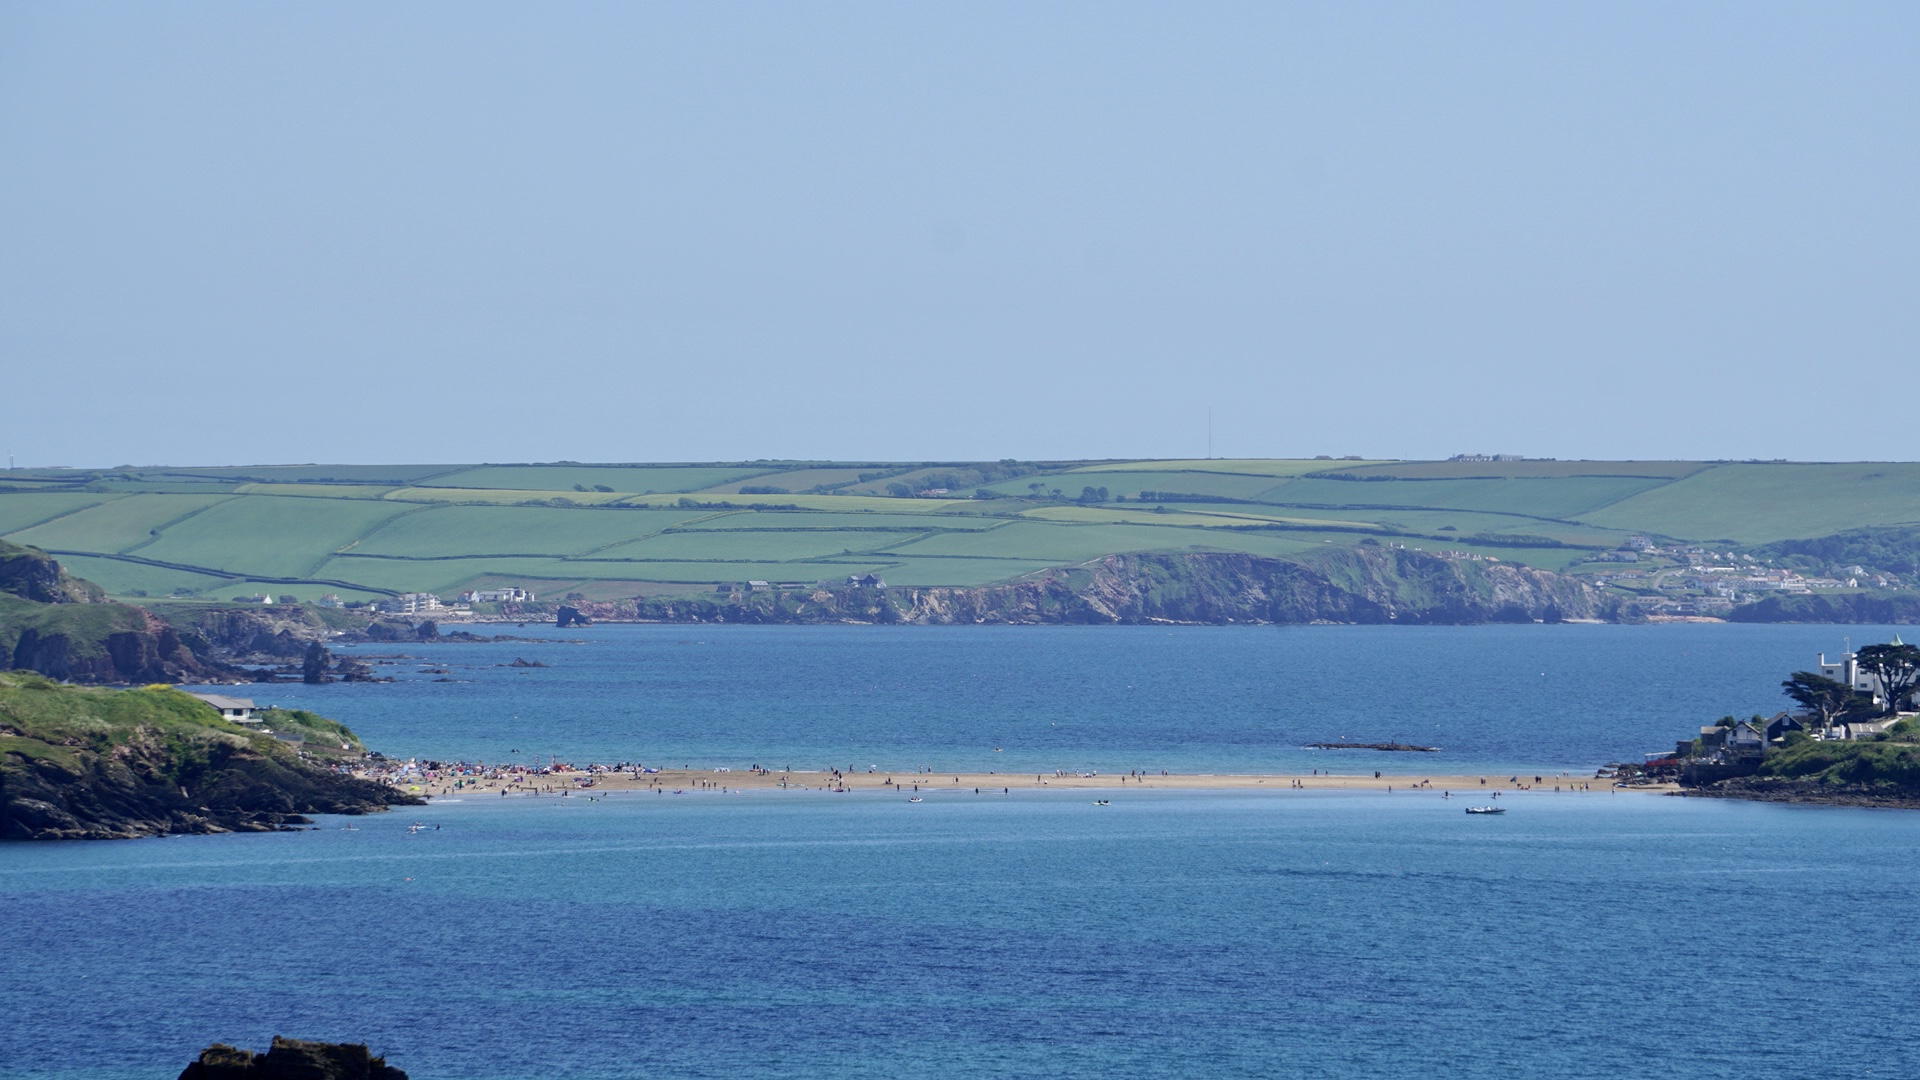

Bigbury on the Sea, Photo by Jason on 28 May 2022

# 1 Import libraries

In [ ]:
import pandas as pd
import numpy as np
import math
import nltk
import collections
from sklearn.feature_extraction.text import TfidfVectorizer

# Visualization
import plotly
import plotly.express as px

import plotly.graph_objects as go
# import chart_studio.plotly as py
import plotly.offline as py
py.init_notebook_mode()
import cufflinks

import en_core_web_lg
nlp = en_core_web_lg.load()

import warnings
warnings.filterwarnings("ignore") 

: 

In [3]:
# Initialize logging.
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# 2 Load News dataset

In [40]:
xl = pd.ExcelFile('data/Sample_GPR_Articles.xlsx')
xl.sheet_names

['Internal_Conflict',
 'External Conflict',
 'Terror Threat',
 'Corruption',
 'Financial Stability',
 'Foreign Policy',
 'Social',
 'Governance',
 'Sea',
 'Land',
 'Air']

In [41]:
dataset = xl.parse('Terror Threat')

In [42]:
dataset.head(1)

,Source,Title,Description,Content,URL
0,NYT,NaN,NaN,"Leader’s Death Is Another Blow for ISIS, but I...",https://www.nytimes.com/2022/02/05/world/middl...


In [45]:
# df_ic = pd.read_excel('data/internal_conflict_Google_News.xlsx')

In [7]:
# df_gov = df_gv_esg.query('search_term == "governance"')

In [38]:
# terro_group_list = pd.read_excel('data/terro_group_list.xlsx',index_col=0)

In [6]:
def check_words_in_tdc(words,x):
        if type(x)== float:
            pass
        else:
            if words.lower() in x.lower():
                return 'yes'
            else:
                return 'no'  

In [7]:
dataset['is_terrorist_in_content'] = dataset['Content'].apply(lambda x : check_words_in_tdc('terrorist',x))
dataset['is_terrorist_in_title'] = dataset['Title'].apply(lambda x : check_words_in_tdc('terrorist',x))
dataset['is_terrorist_in_desc'] = dataset['Description'].apply(lambda x : check_words_in_tdc('terrorist',x))

In [8]:
dataset.head(1)

,Source,Title,Description,Content,URL,is_terrorist_in_content,is_terrorist_in_title,is_terrorist_in_desc
0,NYT,NaN,NaN,"Leader’s Death Is Another Blow for ISIS, but I...",https://www.nytimes.com/2022/02/05/world/middl...,yes,None,None


In [9]:
dataset.query('	is_terrorist_in_content == "yes" and is_terrorist_in_title=="yes"').shape

(0, 8)

In [10]:
dataset.query('	is_terrorist_in_content == "yes" or is_terrorist_in_title=="yes"').shape

(69, 8)

In [14]:
#rename column 
dataset.rename(columns={'Title':'title','Description':'description','Content':'content'},inplace=True)

In [15]:
dataset.head(1)

,Source,title,description,content,URL,is_terrorist_in_content,is_terrorist_in_title,is_terrorist_in_desc
0,NYT,NaN,NaN,"Leader’s Death Is Another Blow for ISIS, but I...",https://www.nytimes.com/2022/02/05/world/middl...,yes,None,None


In [16]:
# dataset.Source.unique()

In [17]:
dataset.isnull().sum()

Source                       1
title                      100
description                100
content                      0
URL                          1
is_terrorist_in_content      0
is_terrorist_in_title      100
is_terrorist_in_desc       100
dtype: int64

# 3 Preprocess Data

In [85]:
def check_st_in_tdc(search_term:list,x):
        if type(x)== str:
            for i in search_term:
                if i.lower() in x.lower():
                    return 'yes'
                else:
                    return 'no' 
        else:
          pass 

In [86]:
def check_words_in_tdc(words,x):

        if type(x) == str:
            if words.lower() in x.lower():
                return 'yes'
            else:
                return 'no'  
        else:
          pass

In [87]:
def Check_KW_ST_in_TDC(df,kw:str):
    df.rename(columns={'Title':'title','Description':'description','Content':'content'},inplace=True)

    df['is_{kw}_in_content'.format(kw=kw)] = df['content'].apply(lambda x : check_words_in_tdc('{kw}'.format(kw=kw),x))
    df['is_{kw}_in_title'.format(kw=kw)] = df['title'].apply(lambda x : check_words_in_tdc('{kw}'.format(kw=kw),x))
    df['is_{kw}_in_desc'.format(kw=kw)]  = df['description'].apply(lambda x : check_words_in_tdc('{kw}'.format(kw=kw),x))

    if 'search_term' in list(df.columns):
    
      search_term = [ i.replace('"',"") for i in list(df.search_term.unique())]
      df['is_st_in_content'] = df['content'].apply(lambda x : check_st_in_tdc(search_term,x))
      df['is_st_in_title'] = df['title'].apply(lambda x : check_st_in_tdc(search_term,x))
      df['is_st_in_desc']  = df['description'].apply(lambda x : check_st_in_tdc(search_term,x))
    else:
        pass
    
    return df  

## 3.1 Merge Title, Descriptipn and Content

In [21]:
# from Utilities.combine_columns import Combine_Col

In [17]:
# combine two columns
def covert_nan(x):
    
    if pd.isna(x):
        return ""
    else:
        return str(x)
    
def Combine_Col(dataset, col_1, col_2):
    
    df_col_1_2 = pd.DataFrame(dataset[col_1]+ ' ' + dataset[col_2].map(covert_nan),columns=[col_1+'_'+col_2])
    new_dataset = pd.concat([df_col_1_2,dataset],axis=1)
    
    return new_dataset

In [23]:
dataset.head(1)

,Source,title,description,content,URL,is_terrorist_in_content,is_terrorist_in_title,is_terrorist_in_desc
0,NYT,NaN,NaN,"Leader’s Death Is Another Blow for ISIS, but I...",https://www.nytimes.com/2022/02/05/world/middl...,yes,None,None


In [1]:
dataset = Combine_Col(dataset,'title','description')
dataset = Combine_Col(dataset,'title_description','content')

In [60]:
dataset.head(1)

,title_description_content,title_description,Source,title,description,content,URL
0,Somalia's President Suspends Prime Minister Ov...,Somalia's President Suspends Prime Minister Ov...,NYT,Somalia's President Suspends Prime Minister Ov...,"The premier, Mohamed Hussein Roble, defied the...",Somalia’s president suspended the country’s pr...,https://www.nytimes.com/2021/12/27/world/afric...


In [25]:
dataset.isnull().sum()

Source                       1
title                      100
description                100
content                      0
URL                          1
is_terrorist_in_content      0
is_terrorist_in_title      100
is_terrorist_in_desc       100
dtype: int64

In [151]:
dataset = dataset.query('title_description_content==title_description_content')

## 3.2 Clean Data

'corruption, government, official, minister, anti, country, president, power, prosecutor, investigation, arrest, political, police, party, graft, money, office, governor, accuse, fight, election, allegation, people, military, company, general, bribe, law, court, involve, trial, face, sentence, leader, prison, drug, protest, corrupt, head, come, administration, member, prime, bank, scheme, body, help, authority, attorney, serve'

In [26]:
non_informative_word = ['accord','add','agency','case','charge','city','counter','day','detain',\
                        'early','hold','include', 'know',\
                        'new','news','order','public','release','report','say','speak','state',\
                        'statement','support','tell','time','website','year','say'\
                        ,'face','office','come','help','serve',     
] 

In [27]:
def Pre_Processing_Keyword(text:str):
    
    # recognize name entities
    doc = nlp(text) 
    name_entities = [str(i) for i in list(doc.ents)]
    
    # remove name entities
    for ent in name_entities:
        if ent in text:
            text = text.replace('{ent}'.format(ent=ent),'')  
    
    doc = nlp(text)    
    df_doc = pd.DataFrame([[t.text, t.is_stop, t.lemma_, t.pos_] for t in doc],\
                      columns=['Token', 'is_stop_word', 'lemma', 'POS'])
    
    lemma = df_doc.query('is_stop_word == False and \
                            POS !="PUNCT" and \
                            POS != "ADP" and \
                            POS != "AUX" and \
                            POS != "PART" and \
                            POS != "SPACE" and \
                            POS != "PROPN" and \
                            POS != "SYM" and \
                            POS != "DATE" and \
                            POS != "NORP" and \
                            POS != "CARDINAL" and \
                            POS != "PERSON" and POS != "NUM"').lemma.values.tolist()
            
    # remove non_informative_word_bigram and key words of which length smaller than 2
    tokens = [i for i in lemma if not i.lower() in non_informative_word and len(i)>2]
    
    # convert list to string in lowercase
    tokens = " ".join(tokens).lower()

    return tokens

In [28]:
Pre_Processing_Keyword('White_company is a clothing company')

'white_company clothing company'

In [29]:
%%time
dataset['TDC'] = dataset['content'].apply(lambda x : Pre_Processing_Keyword(x))

CPU times: user 17.9 s, sys: 10.9 ms, total: 17.9 s
Wall time: 17.9 s


Visualize cleaned data

In [30]:
import spacy
spacy.displacy.render(nlp(dataset.TDC[10]), style="ent", jupyter = True)

# 4 Calculate KW TFIDF Value

In [31]:
dataset.head(1)

,Source,title,description,content,URL,is_terrorist_in_content,is_terrorist_in_title,is_terrorist_in_desc,TDC
0,NYT,NaN,NaN,"Leader’s Death Is Another Blow for ISIS, but I...",https://www.nytimes.com/2022/02/05/world/middl...,yes,None,None,hardly end shadow self likely adapt enduring r...


In [32]:
from Utilities.num_of_words import  Num_of_Words_in_String, Check_Content_Len

In [33]:
dataset['num_of_words']  = dataset['TDC'].apply(lambda x : Num_of_Words_in_String(x))

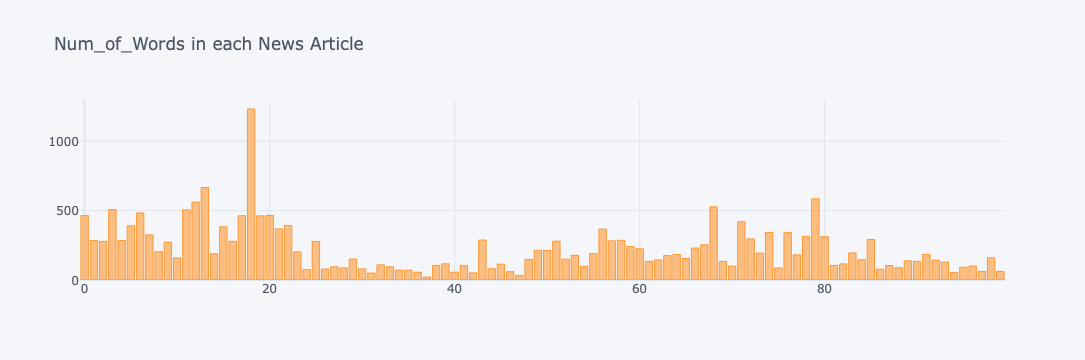

In [34]:
dataset[['num_of_words']].iplot(kind='bar',title='Num_of_Words in each News Article')

In [38]:
len(dataset.TDC[18])

9315

In [39]:
dataset[['num_of_words']].describe()

,num_of_words
count,100.000000
mean,225.110000
std,176.365088
min,21.000000
25%,100.750000
50%,179.500000
75%,289.000000
max,1232.000000


In [40]:
def Compute_TFIDF(text:list):
    """
    input: multiple documents
    return: tfidf value
    """
    vectorizer = TfidfVectorizer(max_features=500, stop_words='english',ngram_range=(1,2))
    TFIDF = vectorizer.fit_transform(text)
    df_TFIDF = pd.DataFrame(TFIDF.toarray(),columns=vectorizer.get_feature_names()).T
    return df_TFIDF

In [41]:
def Documents_List(dataset, col_name):
    """
    input: datset, col_name
    return: a list containing multiple news data
    """
    gpr_text = []
    for i in dataset.index.to_list():
        content = dataset[col_name][i]
        gpr_text.append(content)
    return gpr_text

In [42]:
News_Docs = Documents_List(dataset=dataset, col_name='TDC')

In [43]:
len(News_Docs)

100

In [44]:
df_TFIDF = Compute_TFIDF(text = News_Docs)

In [45]:
df_TFIDF

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ability,0.171730,0.000000,0.000000,0.077183,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000
able,0.000000,0.053160,0.000000,0.079329,0.000000,0.038237,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000
accuse,0.000000,0.000000,0.087035,0.000000,0.044759,0.000000,0.046400,0.000000,0.000000,0.0,...,0.000000,0.000000,0.04478,0.00000,0.000000,0.000000,0.000000,0.090362,0.0,0.13153
act,0.000000,0.035007,0.000000,0.000000,0.000000,0.025180,0.000000,0.034570,0.045782,0.0,...,0.048152,0.048624,0.00000,0.06876,0.000000,0.000000,0.000000,0.085168,0.0,0.00000
act terrorism,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.054052,0.071582,0.0,...,0.075288,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
world,0.073259,0.000000,0.051704,0.000000,0.053179,0.000000,0.027564,0.000000,0.000000,0.0,...,0.121399,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000
wound,0.045433,0.000000,0.064130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.100036,0.000000,0.000000,0.0,0.00000
write,0.179631,0.000000,0.000000,0.032294,0.000000,0.000000,0.000000,0.042741,0.000000,0.0,...,0.000000,0.000000,0.00000,0.00000,0.129199,0.000000,0.068342,0.000000,0.0,0.00000
young,0.000000,0.000000,0.057616,0.000000,0.000000,0.035371,0.184296,0.000000,0.000000,0.0,...,0.000000,0.068303,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000


Calculate the sum of TFIDF values across all sample news articles.

In [46]:
df_TFIDF['col_sum'] = df_TFIDF.apply(lambda x : x.sum(), axis=1)

In [47]:
df_TFIDF.head(1)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,col_sum
ability,0.17173,0.0,0.0,0.077183,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.683568


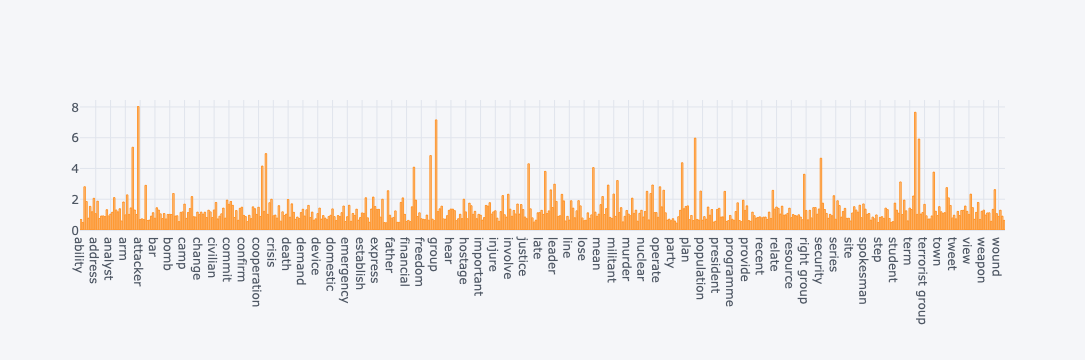

In [48]:
df_TFIDF[['col_sum']].iplot(kind='bar')

In [49]:
df_TFIDF.describe()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,col_sum
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.017183,0.015571,0.016975,0.017379,0.016891,0.012710,0.014958,0.016975,0.013852,0.016919,...,0.013278,0.010213,0.013666,0.007533,0.010494,0.006908,0.010385,0.011738,0.009612,1.297477
std,0.041330,0.041965,0.041416,0.041248,0.041451,0.042920,0.042188,0.041416,0.042565,0.041439,...,0.042747,0.043583,0.042625,0.044126,0.043516,0.044229,0.043542,0.043197,0.043720,0.909908
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.448837
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.798012
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.065320
75%,0.000000,0.000000,0.000000,0.030177,0.000000,0.000000,0.018446,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.422302
max,0.369960,0.437878,0.323144,0.385916,0.438368,0.697747,0.491455,0.306461,0.432805,0.301562,...,0.480061,0.725901,0.369021,0.494279,0.426405,0.795813,0.517326,0.452348,0.351823,8.027819


In [50]:
df_TFIDF.col_sum.mean()

1.297476920027765

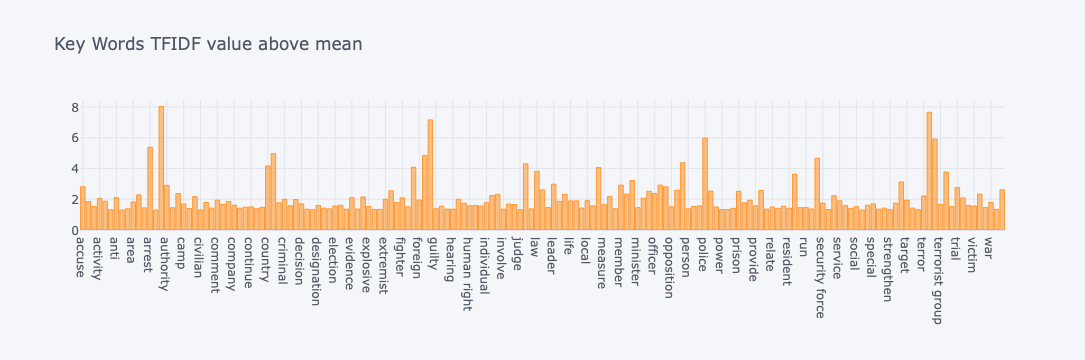

In [51]:
df_TFIDF.query('col_sum > {i}'.format(i = df_TFIDF.col_sum.mean()))[['col_sum']].iplot(kind='bar',title = 'Key Words TFIDF value above mean ')

In [52]:
# key_words_above_avg = list(df_gpr_TFIDF.query('col_sum > {i}'.format(i = df_gpr_TFIDF.col_sum.mean())).index)
# key_words_above_avg

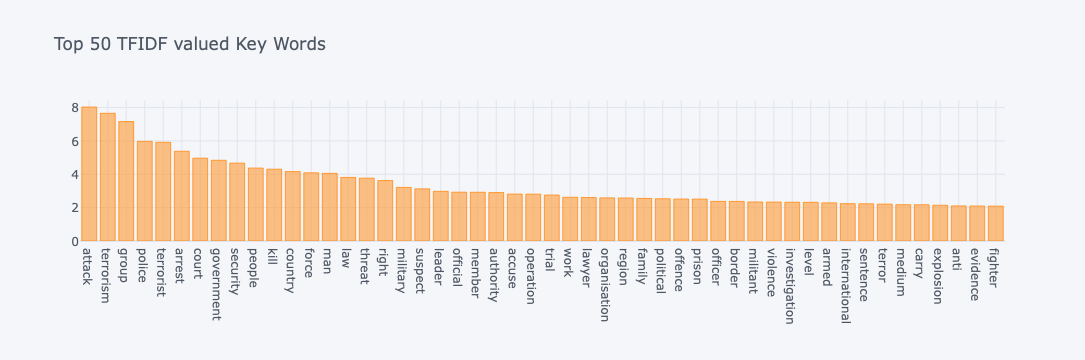

In [53]:
df_TFIDF.sort_values(by='col_sum',ascending=False).iloc[:50,-1:].iplot(kind = 'bar',title='Top 50 TFIDF valued Key Words')

Headmap of Top 50 TFIDF valued Key Words

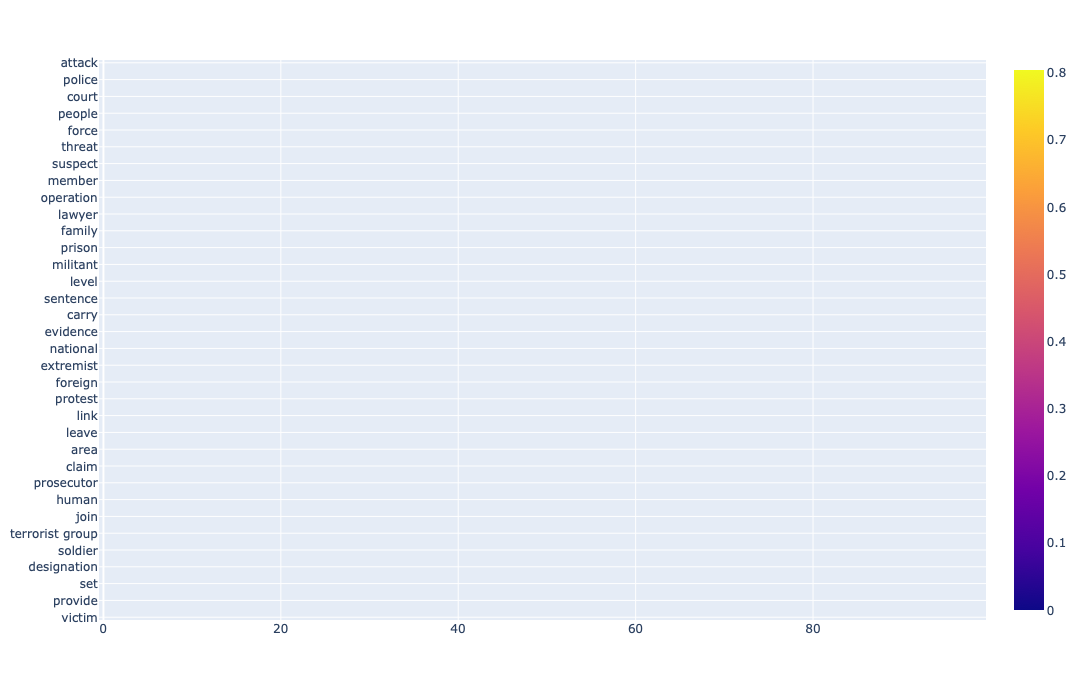

In [54]:
px.imshow(df_TFIDF.sort_values(by='col_sum',ascending=False).iloc[:100,:-1],height=700).show()

In [55]:
", ".join(df_TFIDF.sort_values(by='col_sum',ascending=False).iloc[:50,-1:].index.to_list())

'attack, terrorism, group, police, terrorist, arrest, court, government, security, people, kill, country, force, man, law, threat, right, military, suspect, leader, official, member, authority, accuse, operation, trial, work, lawyer, organisation, region, family, political, offence, prison, officer, border, militant, violence, investigation, level, armed, international, sentence, terror, medium, carry, explosion, anti, evidence, fighter'

In [56]:
KW_LIST = df_TFIDF.sort_values(by='col_sum',ascending=False).iloc[:50,-1:].index.to_list()

# 5 Collocation Detection

In [57]:
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases,ENGLISH_CONNECTOR_WORDS

import nltk
from gensim.test.utils import datapath
from gensim.models.word2vec import Text8Corpus
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()

2022-06-24 14:22:08,836 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2022-06-24 14:22:08,837 : INFO : built Dictionary<12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...> from 9 documents (total 29 corpus positions)
2022-06-24 14:22:08,911 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...> from 9 documents (total 29 corpus positions)", 'datetime': '2022-06-24T14:22:08.837581', 'gensim': '4.2.0', 'python': '3.8.0 (default, Nov  6 2019, 21:49:08) \n[GCC 7.3.0]', 'platform': 'Linux-5.4.0-90-generic-x86_64-with-glibc2.10', 'event': 'created'}


Pointwise Mutual Information


$$ PMI(x;y) = {log} \left( \frac{p(x,y)}{p(x)p(y)} \right) = {log} \left( \frac{p(x|y)}{p(x)} \right) = {log} \left( \frac{p(y|x)}{p(y)} \right)$$

In [58]:
def Detect_Bigram_Phrases(dataset,col_name):

    news = ''
    for i in range(len(dataset)):
        text = dataset[col_name][i]
        news += text

    all_sentences = [j.split() for j in [i for i in news.split('\n') if len(i) > 1]]
    phrases = Phrases(all_sentences, connector_words=ENGLISH_CONNECTOR_WORDS)
    # The Phraser object is used from now on to transform sentences
    bigram = Phraser(phrases)
    # Applying the Phraser to transform our sentences is simply
    all_sentences = list(bigram[all_sentences])

    BIGRAMS = []
    for j in range(len(all_sentences)):
        for i in all_sentences[j]:
            if '_' in i:
                BIGRAMS.append(str(i).lower())

    BIGRAMS = list(set(BIGRAMS))
    BIGRAMS = [i.replace('_',' ') for i in BIGRAMS]
    
    return BIGRAMS

In [59]:
def Detect_Bigram_LLH_PMI(data, col_name, top_n):
    
    Bigram_LLH = []
    # Bigram_PMI = []
    
    for i in data.index.to_list():      

        row = data[col_name][i].split()
        finder = BigramCollocationFinder.from_words(row) # window_size=2
        # finder.apply_freq_filter(1)
        # # finder.apply_word_filter(lambda w: w in (non_informative_word))
        # ignored_words = nltk.corpus.stopwords.words('english')
        # finder.apply_word_filter(lambda w: len(w) < 1 or w.lower() in ignored_words)
      
        top_n_llh = finder.nbest(bigram_measures.likelihood_ratio, top_n)
        # top_n_pmi = finder.nbest(bigram_measures.pmi, top_n)
        
        Bigram_LLH.extend(top_n_llh)
        # Bigram_PMI.extend(top_n_pmi)
        
    Bigram_LLH = list(set(Bigram_LLH))
    df_Bigram_LLH = pd.DataFrame(Bigram_LLH).rename(columns={0:"level_0", 1:"level_1"})
    df_Bigram_LLH['bigram'] = df_Bigram_LLH['level_0'] + " "+ df_Bigram_LLH['level_1']  
    bigram_list = list(df_Bigram_LLH.bigram.values)
        
    return bigram_list

## 5.1 Preprocessing Bigram

In [60]:
non_informative_word_bigram = ['news','release','report','say','speak','state','include',\
                               'face','new','come','take','statement','tell','time','website',\
                               'year','mr.','mrs.','mr','ms','ms.'] 

In [61]:
# spacy.displacy.render(nlp(tokens), style="ent", jupyter = True) 

In [62]:
def Pre_Processing_Bigram(text:str):
    
    # recognize name entities
    doc = nlp(text) 
    name_entities = [str(i) for i in list(doc.ents)]
    
    # remove name entities
    for ent in name_entities:
        if ent in text:
            text = text.replace('{ent}'.format(ent=ent),'')  
    
    doc = nlp(text)    
    df_doc = pd.DataFrame([[t.text, t.is_stop, t.lemma_, t.pos_] for t in doc],\
                      columns=['Token', 'is_stop_word', 'lemma', 'POS'])
    
    lemma = df_doc.query('is_stop_word == False \
                        and POS !="PUNCT" and \
                        POS != "NUM" and \
                        POS != "SPACE" and\
                        POS != "PERSON" and \
                        POS != "DATE" and \
                        lemma != "/n" and \
                        lemma != "." and \
                        lemma != "[" and \
                        lemma != "]" and \
                        lemma != "$" and POS != "PERCENT" \
                        and POS != "MONEY"').lemma.values.tolist()
                         
                               #lemma != "-" and \
            
    # remove non_informative_word_bigram and key words of which length smaller than 2
    tokens = [i for i in lemma if not i.lower() in non_informative_word_bigram and len(i)>2]
    
    # convert list to string in lowercase
    tokens = " ".join(tokens).lower()

    return tokens

In [63]:
# text = Pre_Processing_Bigram(dataset.title_description_content[1])
# spacy.displacy.render(nlp(text), style="ent", jupyter = True) 

In [64]:
import nltk
from nltk import *
# from nltk.book import *
# # # nltk.download()

In [66]:
%%time
dataset['TDC_Bigram'] = dataset['content'].apply(lambda x : Pre_Processing_Bigram(x))

CPU times: user 17.1 s, sys: 19.3 ms, total: 17.1 s
Wall time: 17.1 s


In [67]:
# words list
news_TDC_all = []
for i in dataset.index.to_list():
    news_TDC_all.extend(dataset.TDC_Bigram[i].split())   

In [68]:
len(news_TDC_all)

24373

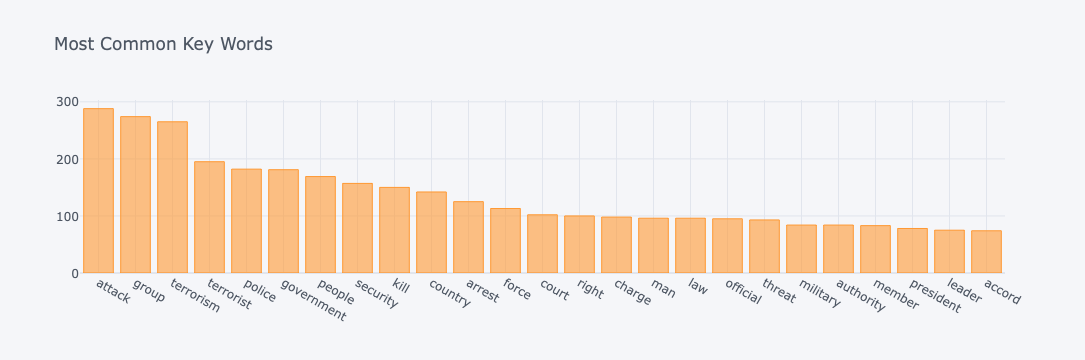

In [69]:
# plot key words list
dfist2=FreqDist(news_TDC_all)
pd.DataFrame(dfist2.values(),index=dfist2.keys(),columns=['freq']).sort_values(by='freq',ascending=False).\
        query('freq > 70').iplot(kind='bar',title='Most Common Key Words')

In [70]:
# detect bigram
Bigram_LLH = Detect_Bigram_LLH_PMI(data=dataset, col_name='TDC_Bigram', top_n=25)

In [71]:
Bigram_Phrases = Detect_Bigram_Phrases(dataset=dataset,col_name='TDC_Bigram')

2022-06-24 14:23:36,279 : INFO : collecting all words and their counts
2022-06-24 14:23:36,280 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2022-06-24 14:23:36,316 : INFO : collected 25750 token types (unigram + bigrams) from a corpus of 24274 words and 1 sentences
2022-06-24 14:23:36,317 : INFO : merged Phrases<25750 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
2022-06-24 14:23:36,318 : INFO : Phrases lifecycle event {'msg': 'built Phrases<25750 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000> in 0.04s', 'datetime': '2022-06-24T14:23:36.318361', 'gensim': '4.2.0', 'python': '3.8.0 (default, Nov  6 2019, 21:49:08) \n[GCC 7.3.0]', 'platform': 'Linux-5.4.0-90-generic-x86_64-with-glibc2.10', 'event': 'created'}
2022-06-24 14:23:36,318 : INFO : exporting phrases from Phrases<25750 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
2022-06-24 14:23:36,380 : INFO : FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<57 

In [72]:
len(Bigram_LLH),len(Bigram_Phrases)

(2381, 55)

In [73]:
# check bigram in common 
LLH = []
for i in Bigram_LLH:
    if i in Bigram_Phrases:
        LLH.append(i)
len(LLH)

52

In [74]:
# check bigram not in common 
LLH_NOT = []
for i in Bigram_LLH:
    if i not in Bigram_Phrases:
        LLH_NOT.append(i)
len(LLH_NOT)

2329

In [75]:
# LLH_NOT

In [76]:
content = 'prime minister, state department central bank'

In [77]:
bigram_list = Bigram_Phrases

In [78]:
for bigram in bigram_list:
    if bigram in content:
        content = content.replace("{bg}".format(bg=bigram),"{b_g}".format(b_g = bigram.replace(' ','_')))

In [79]:
content

'prime_minister, state department central bank'

## 5.2 Calculate Bigram TFIDF values

In [80]:
bigram_list

['counter terrorism',
 'police officer',
 'women hospital',
 'kill people',
 'young people',
 'anti terrorism',
 'right wing',
 'find guilty',
 'nuclear deal',
 'terrorist organization',
 'threat level',
 'foreign ministry',
 'explosive device',
 'human right',
 'extremist terrorist',
 'staff member',
 '-on sea',
 'white supremacist',
 'prime minister',
 'serve sentence',
 'social medium',
 'right group',
 'life prison',
 'decline comment',
 'intelligence service',
 'security force',
 'senior official',
 'anti terror',
 'extremism terrorism',
 'act terrorism',
 'terrorist activity',
 'law enforcement',
 'cross border',
 'civil society',
 'opposition leader',
 'national security',
 'community center',
 'terrorist group',
 'terrorist act',
 'sentence prison',
 'suicide attack',
 'armed group',
 'terrorism offence',
 'suicide bombing',
 'designate terrorist',
 'counter extremism',
 'combat terrorism',
 'outside hospital',
 'militant group',
 'suicide bomber',
 'criminal gang',
 'high prof

In [81]:
def Documents_List_Bigram(dataset, col_name):
    """
    input: datset, col_name
    return: a list containing multiple news data
    """
    gpr_text = []
    for i in dataset.index.to_list():
        content = dataset[col_name][i].lower()
        
        for bigram in bigram_list:
            if bigram in content:
                content = content.replace("{bg}".format(bg=bigram),"{b_g}".format(b_g = bigram.replace(' ','_')))

        gpr_text.append(content)
        
    return gpr_text

In [82]:
#connect identified bigram with underscore

News_Docs_Bigram = Documents_List_Bigram(dataset=dataset, col_name='TDC_Bigram')

In [83]:
df_TFIDF_Bigram = Compute_TFIDF(text = News_Docs_Bigram)

In [84]:
df_TFIDF_Bigram['col_sum'] = df_TFIDF_Bigram.apply(lambda x : x.sum(), axis=1)

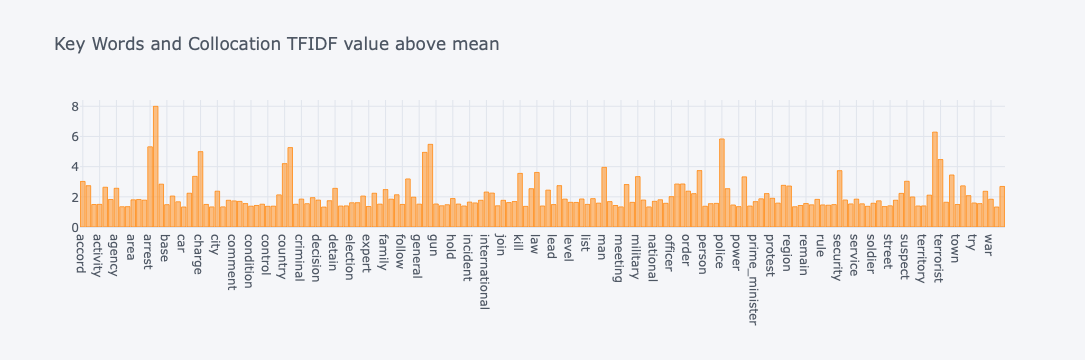

In [85]:
df_TFIDF_Bigram.query('col_sum > {i}'.format(i = df_TFIDF_Bigram.col_sum.mean()))\
                        [['col_sum']].iplot(kind='bar',title = 'Key Words and Collocation TFIDF value above mean ')

In [86]:
len(News_Docs_Bigram)

100

In [87]:
news = []
for i in News_Docs_Bigram:
    news.append(i)

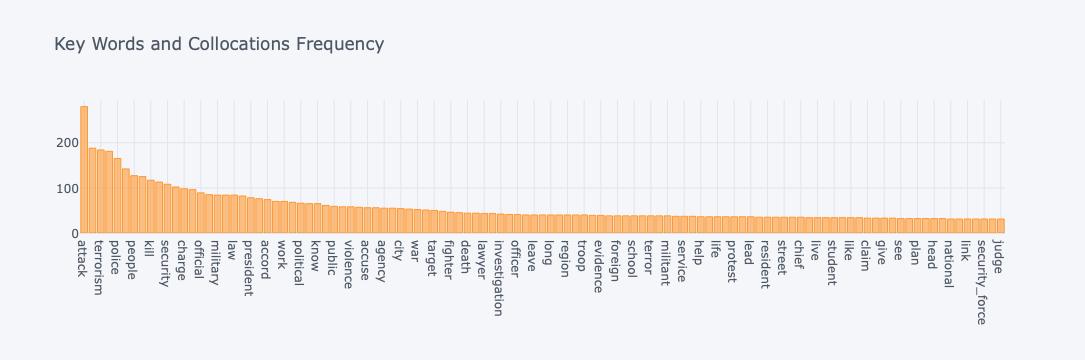

In [88]:
dfist3=FreqDist(" ".join(news).split())
pd.DataFrame(dfist3.values(),index=dfist3.keys(),columns=['freq']).sort_values(by='freq',ascending=False).\
        query('freq > 30').iplot(kind='bar', title = 'Key Words and Collocations Frequency')

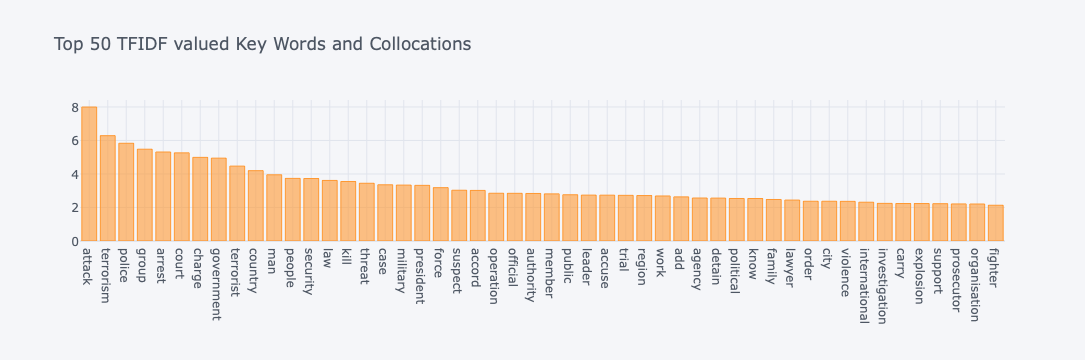

In [89]:
df_TFIDF_Bigram.sort_values(by='col_sum',ascending=False).iloc[:50,-1:]\
                    .iplot(kind = 'bar',title='Top 50 TFIDF valued Key Words and Collocations')

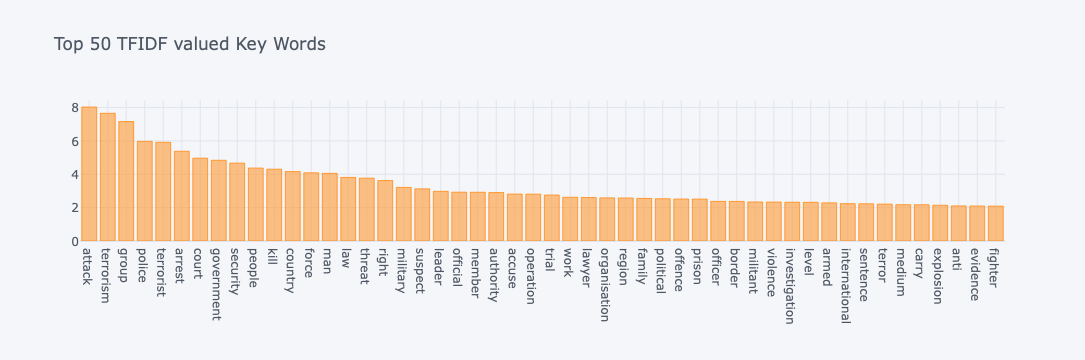

In [90]:
df_TFIDF.sort_values(by='col_sum',ascending=False).iloc[:50,-1:].iplot(kind = 'bar',title='Top 50 TFIDF valued Key Words')

## 5.3 identify KW,SYN and BIGRAM

In [91]:
df_TFIDF_Bigram.sort_values(by='col_sum',ascending=False).iloc[:50,-1:].index.to_list()

['attack',
 'terrorism',
 'police',
 'group',
 'arrest',
 'court',
 'charge',
 'government',
 'terrorist',
 'country',
 'man',
 'people',
 'security',
 'law',
 'kill',
 'threat',
 'case',
 'military',
 'president',
 'force',
 'suspect',
 'accord',
 'operation',
 'official',
 'authority',
 'member',
 'public',
 'leader',
 'accuse',
 'trial',
 'region',
 'work',
 'add',
 'agency',
 'detain',
 'political',
 'know',
 'family',
 'lawyer',
 'order',
 'city',
 'violence',
 'international',
 'investigation',
 'carry',
 'explosion',
 'support',
 'prosecutor',
 'organisation',
 'fighter']

In [122]:
TT_kw = [ 'attack',
 'terrorism',
 'police',
 'arrest',
 'court',
 'government',
 'terrorist',
 'country',
 'people',
 'security',
 'kill',
 'threat',
 'military',
 'president',
 'trial',
 'detain',
 'political',
 'violence',
 'investigation',
 'explosion',
 'prosecutor',
 'fighter']

In [92]:
[i for i in df_TFIDF_Bigram.sort_values(by='col_sum',ascending=False).iloc[:400,-1:].index if '_' in i]

['counter_terrorism',
 'security_force',
 'prime_minister',
 'terrorist_group',
 'human_right',
 'kill_people',
 'anti_terrorism',
 'social_medium',
 'national_security',
 'right_group',
 'law_enforcement',
 'armed_group',
 'terrorist_organisation',
 'civil_society',
 'militant_group',
 'act_terrorism']

In [123]:
TT_bigram = ['counter_terrorism',
             'security_force',
             'prime_minister',
             'terrorist_group',
             'human_right',
             'kill_people',
             'anti_terrorism',
             'national_security',
             'law_enforcement',
             'armed_group',
             'terrorist_organisation',
             'civil_society',
             'militant_group',
             'act_terrorism']

In [93]:
from gensim.models import Word2Vec
gpr_w2v_model = Word2Vec.load("/var/coriolis/jason/News_NLP/models/gpr_word2vec.model_v3")

2022-06-24 14:28:44,486 : INFO : loading Word2Vec object from /var/coriolis/jason/News_NLP/models/gpr_word2vec.model_v3
2022-06-24 14:28:44,776 : INFO : loading wv recursively from /var/coriolis/jason/News_NLP/models/gpr_word2vec.model_v3.wv.* with mmap=None
2022-06-24 14:28:44,777 : INFO : loading vectors from /var/coriolis/jason/News_NLP/models/gpr_word2vec.model_v3.wv.vectors.npy with mmap=None
2022-06-24 14:28:47,275 : INFO : loading syn1neg from /var/coriolis/jason/News_NLP/models/gpr_word2vec.model_v3.syn1neg.npy with mmap=None
2022-06-24 14:28:49,739 : INFO : setting ignored attribute cum_table to None
2022-06-24 14:28:56,151 : INFO : Word2Vec lifecycle event {'fname': '/var/coriolis/jason/News_NLP/models/gpr_word2vec.model_v3', 'datetime': '2022-06-24T14:28:56.151125', 'gensim': '4.2.0', 'python': '3.8.0 (default, Nov  6 2019, 21:49:08) \n[GCC 7.3.0]', 'platform': 'Linux-5.4.0-90-generic-x86_64-with-glibc2.10', 'event': 'loaded'}


In [25]:
word = 'Terrorist'
vector = gpr_w2v_model.wv[word]
sims = gpr_w2v_model.wv.most_similar(word, topn=50)
# sims
syns = [sims[i][0] for i in range(len(sims))]
syns

['Extremist',
 'Designated_Global',
 'Terror',
 'Carried_Out',
 'Terror_Group',
 'Drone_Strike',
 'Carry_Out',
 'Detention',
 '“Specially',
 "'Enormous'",
 'Custody',
 '911Style',
 'Attempt',
 'Here’s_How',
 'Civilian_Casualties',
 'Pulwama_Terror',
 'USBacked',
 'as_a_Specially',
 'Investigating',
 'Have_Been',
 'Conspiracy',
 'Execution',
 'Will_Not',
 'Man_Convicted',
 'Plotted',
 'Notorious',
 'Justified',
 'Woman_Who',
 'Exposes',
 'Accused_Of',
 'Ends',
 'Fight_Against',
 'Allegedly',
 'To_Protect',
 'LeftWing',
 'Suicide_Attack',
 'Investigated',
 'Airstrike',
 'Dead_After',
 'Global_Terrorist',
 'Says_It',
 'Hostage',
 'Are_Being',
 'Violates',
 'Thwarted',
 '1_Million',
 'Resurgence',
 'Terrorist_Group',
 'White_Supremacist',
 'Yemen_Blockade']

In [124]:
TT_syns = ['terror threat',
 'terrorist',
 'terrorist_group',
 'terrorist_organization',
 'counterterrorism',
 'international_terrorism',
 'terror_groups',
 'extremism_and_terrorism',
 'Islamist_extremism',
 'terrorist_groups',
 'terrorism_and_extremism',
 'religious_extremism',
 'Islamist_terrorism',
 'terrorist_activity',
 'domestic_terrorism',
 'jihadism',
 'ISIS',
 'Al_Qaeda',
 'international_terrorism',
 'terrorism',
 'violent_extremism',
 'terror_groups',
 'extremism_and_terrorism',
 'Islamist_extremism',
 'terrorist_groups',
 'Islamic_extremism',
 'religious_extremism',
 'Islamist_terrorism',
 'terrorist_activity',
 'domestic_terrorism',
 'jihadism',
 'terrorist_organizations',
 'crossborder_terrorism',
 'menace_of_terrorism',
 'extremist_violence',
 'terrorist_activities',
 'radical_Islam',
 'terrorist_networks',
 'extremist_groups',
 'radical_Islamic',
 'fighting_terrorism',
 'combating_terrorism',
 'Islamist_extremists',
]

In [10]:
TT_syns = [i.replace('_',' ') for i in terr_syns]

In [127]:
# TT_kw.extend(terro_group_list)
TT_kw.extend(TT_bigram)
TT_kw.extend(TT_syns)

In [128]:
TT_kw = list(set(TT_kw))

In [129]:
len(TT_kw)

66

In [130]:
TT_kw = list(set([i.lower().replace('_',' ') for i in TT_kw]))

In [131]:
TT_kw

['violence',
 'political',
 'terror threat',
 'islamic extremism',
 'terrorist organization',
 'people',
 'explosion',
 'jihadism',
 'fighter',
 'human right',
 'counterterrorism',
 'al qaeda',
 'islamist terrorism',
 'terrorist group',
 'act terrorism',
 'extremism and terrorism',
 'terrorist networks',
 'counter terrorism',
 'civil society',
 'trial',
 'international terrorism',
 'islamist extremism',
 'threat',
 'attack',
 'religious extremism',
 'detain',
 'terrorist activity',
 'kill',
 'kill people',
 'law enforcement',
 'government',
 'anti terrorism',
 'prime minister',
 'police',
 'national security',
 'terrorist organizations',
 'terrorist activities',
 'security',
 'president',
 'crossborder terrorism',
 'radical islamic',
 'extremist violence',
 'isis',
 'menace of terrorism',
 'islamist extremists',
 'terrorism',
 'arrest',
 'militant group',
 'violent extremism',
 'domestic terrorism',
 'radical islam',
 'investigation',
 'prosecutor',
 'terrorism and extremism',
 'securi

# 6. Categorise Keywords and Bigram

## 6.1 Kmeans

In [132]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score
from minisom import MiniSom
import matplotlib.pyplot as plt

In [133]:
identified_kw = TT_kw

In [134]:
df_identified_kw = pd.DataFrame(identified_kw,columns=['kw'])

In [135]:
df_identified_kw['vector'] = df_identified_kw['kw'].apply(lambda x: nlp(x.replace('_',' ')).vector)
# set keywords as index
V = df_identified_kw["vector"].to_list()
df_KW = pd.concat([df_identified_kw[['kw']],pd.DataFrame(V)],axis=1).set_index('kw')

In [136]:
df_KW

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
kw,,,,,,,,,,,,,,,,,,,,,
violence,-0.631530,0.182210,0.319990,-0.052668,0.254270,-0.329150,-0.249050,0.774540,0.034287,3.21440,...,0.089968,0.097875,-0.063452,0.218260,-0.269420,0.429590,-0.393000,-0.149540,-0.297550,0.360430
political,-0.213570,-0.192750,0.874790,0.177730,-0.189390,0.220880,-0.581840,0.228510,0.040999,3.87100,...,-0.278720,0.286730,0.226560,-0.058374,0.061440,-0.000503,-0.013898,-0.010907,-0.248730,-0.032963
terror threat,-0.714005,-0.023416,0.394560,0.285150,0.107025,-0.084507,-0.333230,0.476375,-0.276210,2.68810,...,-0.166429,0.248490,-0.094317,-0.002761,0.156964,0.424022,0.020230,0.082960,-0.078149,0.203575
islamic extremism,-0.584840,-0.149865,0.442439,0.875480,0.484540,-0.244226,-0.351251,0.250389,0.139977,1.19281,...,0.569370,0.069954,-0.232765,-0.134305,0.189356,0.075156,0.112905,0.356230,-0.142533,0.474605
terrorist organization,-0.360180,-0.246743,0.259445,0.215717,0.173912,0.089889,-0.596235,0.151056,0.443815,3.07725,...,0.017930,0.321090,0.073955,-0.050965,-0.061670,-0.384935,-0.092468,0.169606,-0.407765,0.446725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
extremist groups,-0.253940,-0.266464,0.048505,0.520790,0.401040,0.070840,-0.595100,0.352525,0.223114,2.36305,...,0.184110,-0.014990,0.196105,-0.081970,0.035510,0.103670,0.005892,0.005535,-0.037128,0.351205
terrorist organisation,-0.323244,-0.171025,0.264045,0.213129,0.060895,0.001314,-0.533340,0.060350,0.297250,2.64865,...,-0.114234,0.444540,0.104650,-0.069122,0.262085,-0.069380,0.022870,0.147352,-0.158597,0.536145
court,0.188290,0.372940,0.278610,-0.296220,0.222570,-0.266260,0.098941,-0.321530,0.193720,3.59600,...,0.032343,-0.581230,-0.113520,-0.295590,-0.484890,-0.058600,0.621820,-0.338880,0.436410,0.205710


In [137]:
df_KW.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
295    0
296    0
297    0
298    0
299    0
Length: 300, dtype: int64

In [138]:
# calculate inertia
n = len(df_KW)
n_clusters = range(2, n)
inertia = []

for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(df_KW)
    inertia.append(kmeans.inertia_)

In [139]:
relative_inertia = np.divide(inertia,inertia[0])
df_inertia = pd.concat([pd.DataFrame(inertia,columns=['inertia']),\
           pd.DataFrame(relative_inertia,columns=['relative_inertia'])],axis=1)

In [140]:
df_inertia

,inertia,relative_inertia
0,1.245978e+03,1.000000e+00
1,1.150514e+03,9.233823e-01
2,1.095665e+03,8.793618e-01
3,1.008672e+03,8.095429e-01
4,9.624409e+02,7.724383e-01
...,...,...
59,8.499907e+00,6.821876e-03
60,5.791858e+00,4.648444e-03
61,3.558327e+00,2.855851e-03
62,1.562731e+00,1.254220e-03


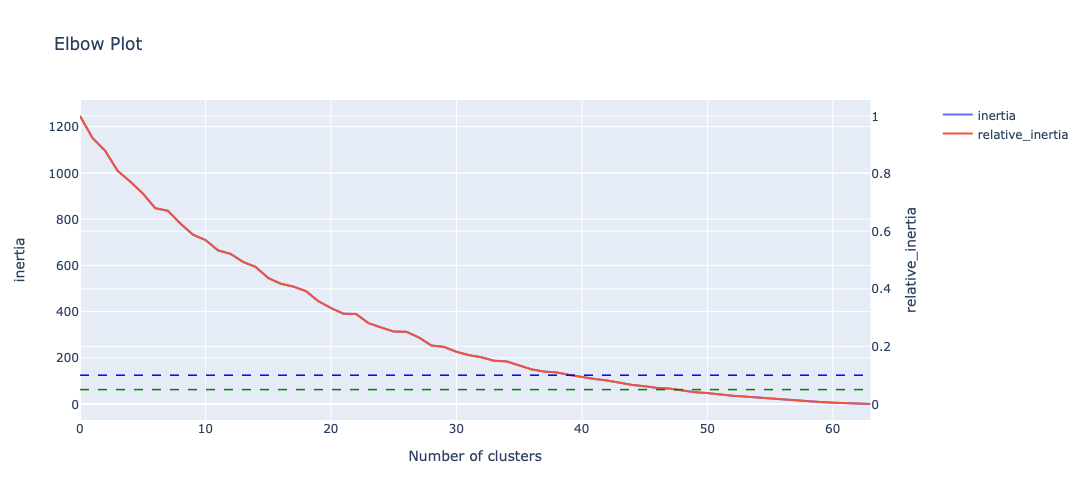

In [141]:
# plot Elbow Plot
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=df_inertia.index.to_list(), y=df_inertia.inertia.to_list(), name="inertia"),secondary_y=False)

fig.add_trace(
    go.Scatter(x=df_inertia.index.to_list(), y=df_inertia.relative_inertia.to_list(), name="relative_inertia"),secondary_y=True)

fig.add_hline(y=0.05,secondary_y=True,name="5% relative inertia",line_width=1.5, line_dash="dash", line_color="green")
fig.add_hline(y=0.1,secondary_y=True,name="10% relative inertia",line_width=1.5, line_dash="dash", line_color="blue")

fig.update_layout(title_text="Elbow Plot",width=800,height=500)
fig.update_xaxes(title_text="Number of clusters")

fig.update_yaxes(title_text="inertia", secondary_y=False)
fig.update_yaxes(title_text="relative_inertia", secondary_y=True)
fig.show()

In [142]:
# silhouette_score as a function of number of clusters
ss = []
cluster_range = np.linspace(start=2, stop=len(df_KW)-1, num=len(df_KW)-2, endpoint=True,dtype=int)
for n in cluster_range:
    pipe = Pipeline([("normalization", MinMaxScaler()), ("cluster", KMeans(n_clusters=n, random_state=42))])
    # Fit and transform Model
    pipe.fit_transform(df_KW)
    labels = pipe['cluster'].labels_
    ss.append(silhouette_score(df_KW, labels, metric = 'euclidean'))

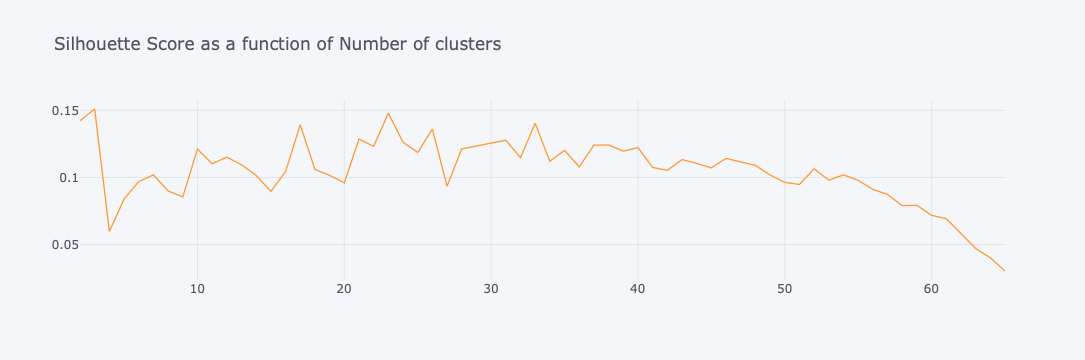

In [143]:
pd.concat([pd.DataFrame(cluster_range,columns=['n_clusters']),\
           pd.DataFrame(ss,columns=['silhouette_score'])],axis=1).set_index('n_clusters')\
                        .iplot(title='Silhouette Score as a function of Number of clusters ')

Both Silhouette Score and Elbow plot suggest the most approaciate number of clusters is 11, however, considering the the totoal number of key words, set n_cluster as 5.

In [147]:
pipe = Pipeline([("normalization", StandardScaler()), ("cluster", KMeans(n_clusters=7, random_state=42))])
# Fit and transform Model
pipe.fit_transform(df_KW)
labels = pipe['cluster'].labels_

In [148]:
df_KW['cluster'] = labels

In [149]:
kw_cluster = df_KW[['cluster']].reset_index().sort_values(by='cluster').reset_index(drop=True)

In [150]:
kw_cluster.to_excel('data/TT_kw_cluster.xlsx')

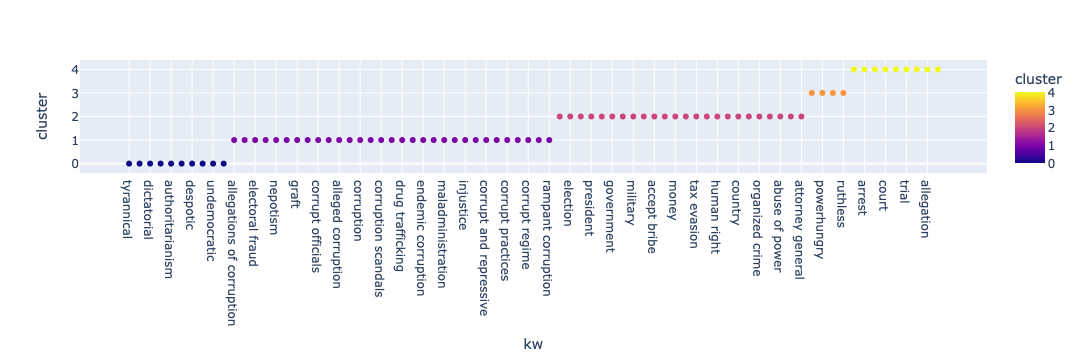

In [170]:
px.scatter(kw_cluster, y='cluster', x="kw", color='cluster').show()

## 6.2 Self Organizing Maps

In [171]:
cluster = kw_cluster

In [172]:
cluster

,kw,cluster
0,tyrannical,0
1,authoritarian,0
2,dictatorial,0
3,kleptocratic,0
4,authoritarianism,0
...,...,...
73,plead guilty,4
74,trial,4
75,prosecutor,4
76,allegation,4


In [175]:
cluster['vector'] = cluster['kw'].apply(lambda x: nlp(x).vector)
# cluster['vector'] = cluster['kw'].apply(lambda x: gpr_w2v_model.wv[x])
V = cluster["vector"].to_list()
data = pd.concat([cluster[['kw']],pd.DataFrame(V)],axis=1).set_index('kw')
#init the weight
data_som = StandardScaler().fit_transform(data)
som = MiniSom(12, 12, data.shape[1], sigma=5, learning_rate=0.5, random_seed=42,topology='hexagonal')
# Initialize with random weights
som.random_weights_init(data_som)
# Trains SOM with 10000 iterations
som.train_batch(data_som,num_iteration=1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 12.263693692756124


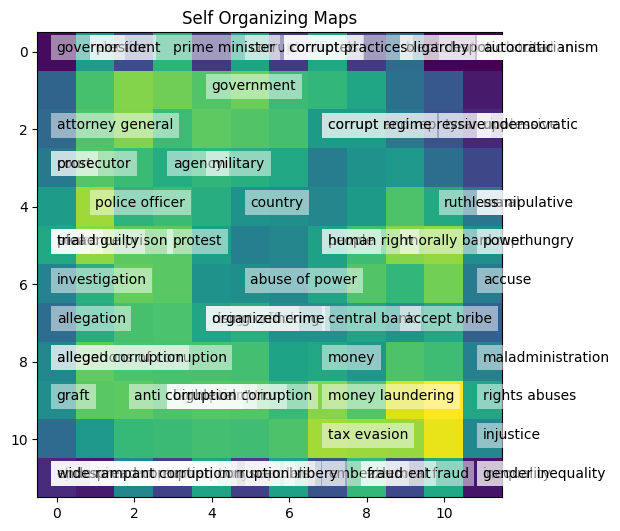

In [176]:
# Plot SOM
plt.figure(figsize=(6, 12))
for ix in range(len(data_som)):
    winner = som.winner(data_som[ix])
    plt.text(winner[0], winner[1], cluster.kw[ix], bbox=dict(facecolor='white',alpha=0.5, lw=0)) 
plt.imshow(som.distance_map())
plt.grid(False)
plt.title('Self Organizing Maps')
plt.show()

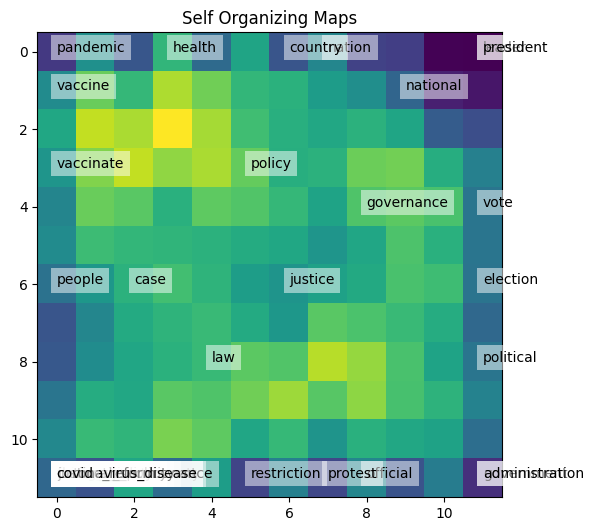

In [267]:
# Plot SOM
plt.figure(figsize=(6, 12))
for ix in range(len(data_som)):
    winner = som.winner(data_som[ix])
    plt.text(winner[0], winner[1], cluster.kw[ix], bbox=dict(facecolor='white',alpha=0.5, lw=0)) 
plt.imshow(som.distance_map())
plt.grid(False)
plt.title('Self Organizing Maps')
plt.show()

# 7. Retrieve News Articles

In [4]:
terro_group_list = pd.read_excel('data/terro_group_list.xlsx')
terro_group_list =terro_group_list.terro_group.to_list()

In [5]:
# kw_cluster = kw_cluster.query('generic!=1')

In [6]:
TT_kw = pd.read_excel('data/TT_kw_cluster.xlsx')

In [10]:
TT_kw = TT_kw.kw.to_list()

In [11]:
TT_kw.extend(terro_group_list)

In [12]:
len(TT_kw)

152

In [23]:
KEY_WORDS = ['"{i}"'.format(i=i) if ' ' in i  else i for i in TT_kw ]

In [24]:
KEY_WORDS

['"terrorist group"',
 '"terrorist organizations"',
 '"terrorist activities"',
 '"terrorist networks"',
 '"militant group"',
 '"al qaeda"',
 'counterterrorism',
 '"terrorist activity"',
 '"terrorist organisation"',
 'terrorist',
 '"extremist groups"',
 '"terrorist organization"',
 '"terror groups"',
 '"terrorist groups"',
 '"terrorism and extremism"',
 '"crossborder terrorism"',
 '"radical islamic"',
 '"extremist violence"',
 '"menace of terrorism"',
 'terrorism',
 '"violent extremism"',
 '"anti terrorism"',
 '"domestic terrorism"',
 '"fighting terrorism"',
 '"radical islam"',
 '"islamist extremists"',
 'violence',
 '"combating terrorism"',
 'jihadism',
 '"islamist terrorism"',
 '"act terrorism"',
 'political',
 '"extremism and terrorism"',
 '"counter terrorism"',
 '"religious extremism"',
 '"islamic extremism"',
 '"international terrorism"',
 '"islamist extremism"',
 '"security force"',
 '"civil society"',
 'military',
 '"kill people"',
 'people',
 'security',
 '"national security"',


In [154]:
top_50 = df_TFIDF_Bigram.sort_values(by='col_sum',ascending=False).iloc[:50,-1:].index.to_list()

In [155]:
top_50 = ", ".join([i.replace('_',' ') for i in top_50])
top_50

'attack, terrorism, police, group, arrest, court, charge, government, terrorist, country, man, people, security, law, kill, threat, case, military, president, force, suspect, accord, operation, official, authority, member, public, leader, accuse, trial, region, work, add, agency, detain, political, know, family, lawyer, order, city, violence, international, investigation, carry, explosion, support, prosecutor, organisation, fighter'

In [156]:
myText = open(r'data/TT_top_50.txt','w')
myString = top_50
myText.write(myString)
myText.close()

In [22]:
top_50 = 'attack, terrorism, police, group, arrest, court, charge, government, terrorist, country, man, people, security, law, kill, threat, case, military, president, force, suspect, accord, operation, official, authority, member, public, leader, accuse, trial, region, work, add, agency, detain, political, know, family, lawyer, order, city, violence, international, investigation, carry, explosion, support, prosecutor, organisation, fighter'

In [19]:
corr = pd.read_csv('data/corruption_tran_2022_Jan01_Jun20.csv',index_col=0)

In [31]:
corr.isnull().sum()

source_name        0
author         32268
title              0
content            0
description     1016
publishedAt        0
search_term        0
url                0
dtype: int64

In [30]:
corr.shape

(182266, 8)

In [28]:
corr = corr.query('publishedAt==publishedAt')

In [32]:
corr = Combine_Col(corr,'title','description')
corr = Combine_Col(corr,'title_description','content')

In [33]:
corr.head(1)

,title_description_content,title_description,source_name,author,title,content,description,publishedAt,search_term,url
news_id,,,,,,,,,,
67177738-d581-452e-ab07-0eb187c40272,Long-derided French dressing freed from strict...,Long-derided French dressing freed from strict...,The Guardian,Matthew Cantor,Long-derided French dressing freed from strict...,The US governments tyrannical reign over a cla...,Federal authorities have insisted on standards...,2022-01-14T11:00:08Z,tyrannical,https://amp.theguardian.com/food/2022/jan/14/f...


In [34]:
corr.isnull().sum()

title_description_content        0
title_description                0
source_name                      0
author                       32268
title                            0
content                          0
description                   1016
publishedAt                      0
search_term                      0
url                              0
dtype: int64

In [36]:
%%time
df_corr_sim = Spacy_Similarity(corr,'title_description_content',top_50)

182266it [3:26:18, 14.72it/s]

CPU times: user 3h 25min 57s, sys: 34.4 s, total: 3h 26min 32s
Wall time: 3h 26min 18s


In [66]:
df_corr_sim.head(1)

,spacy_sim_title_description_content,title_description_content,title_description,source_name,author,title,content,description,publishedAt,search_term,url
news_id,,,,,,,,,,,
67177738-d581-452e-ab07-0eb187c40272,0.661076,Long-derided French dressing freed from strict...,Long-derided French dressing freed from strict...,The Guardian,Matthew Cantor,Long-derided French dressing freed from strict...,The US governments tyrannical reign over a cla...,Federal authorities have insisted on standards...,2022-01-14T11:00:08Z,tyrannical,https://amp.theguardian.com/food/2022/jan/14/f...


In [67]:
df_corr_sim.rename(columns={'spacy_sim_title_description_content':'TDC_sim'},inplace=True)

In [68]:
df_corr_sim.head(1)

,TDC_sim,title_description_content,title_description,source_name,author,title,content,description,publishedAt,search_term,url
news_id,,,,,,,,,,,
67177738-d581-452e-ab07-0eb187c40272,0.661076,Long-derided French dressing freed from strict...,Long-derided French dressing freed from strict...,The Guardian,Matthew Cantor,Long-derided French dressing freed from strict...,The US governments tyrannical reign over a cla...,Federal authorities have insisted on standards...,2022-01-14T11:00:08Z,tyrannical,https://amp.theguardian.com/food/2022/jan/14/f...


In [80]:
df_corr_sim.shape

(182266, 11)

In [87]:
df_corr_sim.iloc[10000:10001,:]

,TDC_sim,title_description_content,title_description,source_name,author,title,content,description,publishedAt,search_term,url
news_id,,,,,,,,,,,
0b977cf4-a472-465a-b284-f6ced0ced3c8,0.670122,Longtime Putin Adviser Says Russian Leader Is ...,Longtime Putin Adviser Says Russian Leader Is ...,Radio Free Europe/ Radio Liberty,RFE/RL's Georgian Service,Longtime Putin Adviser Says Russian Leader Is ...,Russian President Vladimir Putin has made a gr...,"Gleb Pavlovsky, a Kremlin spin doctor and form...",2022-04-05T17:00:28Z,authoritarian,https://www.rferl.org/a/russia-ukraine-invasio...


In [89]:
corr_sim_kw = Check_KW_ST_in_TDC(df=df_corr_sim, kw='corruption')

In [90]:
corr_sim_kw.shape

(182266, 17)

In [91]:
corr_sim_kw.query('TDC_sim > 0.7408 ').shape

(1015, 17)

In [92]:
corruption_1015 = corr_sim_kw.query('TDC_sim > 0.7408').sort_values(by=['TDC_sim'], ascending=False)

In [98]:
corruption_1015.columns

Index(['TDC_sim', 'title_description_content', 'title_description',
       'source_name', 'author', 'title', 'content', 'description',
       'publishedAt', 'search_term', 'url', 'is_corruption_in_content',
       'is_corruption_in_title', 'is_corruption_in_desc', 'is_st_in_content',
       'is_st_in_title', 'is_st_in_desc'],
      dtype='object')

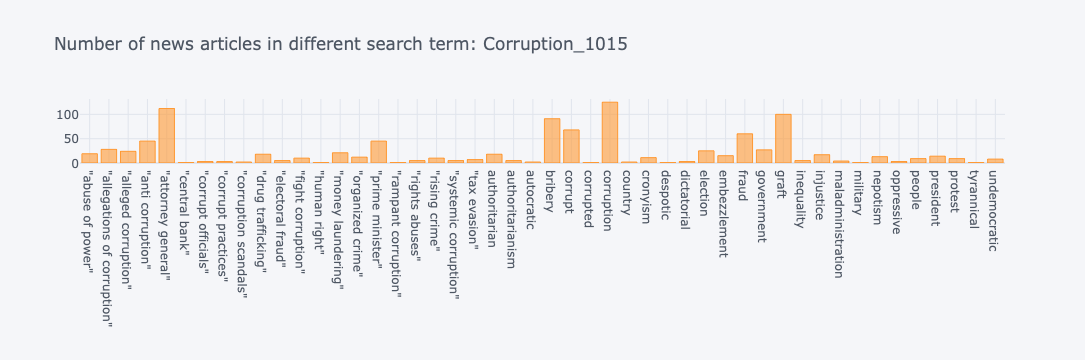

In [130]:
pd.DataFrame(corruption_1015.reset_index().groupby(['search_term'])['news_id'].count())\
                                            .iplot(kind='bar',title='Number of news articles in different search term: Corruption_1015')

In [112]:
dates=['April-20', 'April-21', 'April-22', 'April-23','April-24','April-25']
income=[10,20,10,15,10,12]
expenses=[3,8,4,5,6,10]

df=pd.DataFrame({"Date":dates,
                "Income":income,
                "Expenses":expenses})

In [123]:
order = ['Labeller','Primary Country','Primary Region','Primary City','Secondary Countries','Secondary Regions','Secondary Cities','Corruption','Internal Conflict','External Conflict','Terror Threat',\
'Financial Stability','Foreign Policy','Environment','Social','Governance','Comments']
for i in order:
    url[i] = ''

In [122]:
url = corruption_1015.iloc[:,:11]

In [127]:
corruption_1015_new = pd.concat([url,corruption_1015.iloc[:,11:]],axis=1)

In [128]:
corruption_1015_new.to_excel('data/corruption_1015_new.xlsx')

In [94]:
list(corruption_1015.search_term.unique())

['bribery',
 '"anti corruption"',
 'graft',
 'corruption',
 '"fight corruption"',
 'undemocratic',
 '"allegations of corruption"',
 '"alleged corruption"',
 'people',
 '"electoral fraud"',
 'embezzlement',
 '"systemic corruption"',
 'fraud',
 '"organized crime"',
 '"prime minister"',
 '"attorney general"',
 'authoritarian',
 '"central bank"',
 'election',
 'government',
 'nepotism',
 'cronyism',
 'corrupt',
 'corrupted',
 'country',
 '"drug trafficking"',
 '"corruption scandals"',
 '"human right"',
 'maladministration',
 '"tax evasion"',
 '"abuse of power"',
 '"money laundering"',
 'protest',
 '"rising crime"',
 '"rights abuses"',
 'president',
 'tyrannical',
 '"corrupt officials"',
 '"corrupt practices"',
 'oppressive',
 'injustice',
 'authoritarianism',
 'inequality',
 'dictatorial',
 '"rampant corruption"',
 'autocratic',
 'despotic',
 'military']

In [69]:
compare

,min,mean,75%,max
sample,0.627215,0.715275,0.733677,0.754442
food,0.413265,0.636069,0.667692,0.734747
sport,0.283259,0.599548,0.639112,0.716192
financial stability,0.203908,0.641865,0.670518,0.723244
foreign policy,0.453424,0.674258,0.696940,0.742820
armed conflict,0.454372,0.669918,0.686931,0.756160
terrorist,0.266279,0.659046,0.696823,0.732824
corruption,0.368353,0.672185,0.714371,0.752338


In [45]:
dataset.head(1)

,Source,Title,Description,Content,URL
0,NYT,NaN,NaN,"Leader’s Death Is Another Blow for ISIS, but I...",https://www.nytimes.com/2022/02/05/world/middl...


In [46]:
df_sample_sim = Spacy_Similarity(dataset,'Content',top_50)

100it [00:04, 22.44it/s]


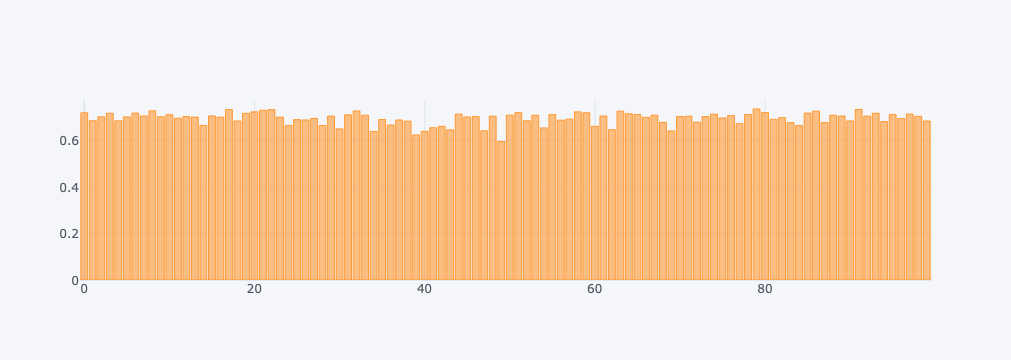

In [48]:
df_sample_sim[['spacy_sim_Content']].iplot(kind='bar')

In [50]:
df_sample_sim[['spacy_sim_Content']].describe()

,spacy_sim_Content
count,100.000000
mean,0.695445
std,0.026631
min,0.596735
25%,0.684490
50%,0.702872
75%,0.712441
max,0.736417


In [52]:
df_sample_sim.query('spacy_sim_Content>0.6954').shape

(62, 6)

In [53]:
fourtopics = pd.read_excel('data/fourtopics_text.xlsx')

In [54]:
fourtopics = Combine_Col(fourtopics,'title','description')
fourtopics = Combine_Col(fourtopics,'title_description','content')

In [55]:
fourtopics.head(1)

,title_description_content,title_description,news_id,source_name,author,title,content,description,publishedAt,search_term,url
0,These Food Prices Actually Went Down This Mont...,These Food Prices Actually Went Down This Mont...,227f00ff-f33d-4026-b8b0-ca5f6bd6497f,Lifehacker.com,Jonathan van Halem,These Food Prices Actually Went Down This Month,The Bureau of Labor Statistics released their ...,The Bureau of Labor Statistics released their ...,2022-06-10T21:30:00Z,food,https://lifehacker.com/these-food-prices-actua...


In [56]:
fourtopics_sim = Spacy_Similarity(fourtopics,'title_description_content',top_50)

3317it [03:20, 16.53it/s]


In [57]:
pd.DataFrame(fourtopics.groupby(['search_term'])['news_id'].count())

,news_id
search_term,
'armed conflict',460
'financial stability',481
'foreign policy',469
corruption,452
food,499
sport,490
terrorist,466


In [58]:
fourtopics_sim.head(1)

,spacy_sim_title_description_content,title_description_content,title_description,news_id,source_name,author,title,content,description,publishedAt,search_term,url
0,0.623892,These Food Prices Actually Went Down This Mont...,These Food Prices Actually Went Down This Mont...,227f00ff-f33d-4026-b8b0-ca5f6bd6497f,Lifehacker.com,Jonathan van Halem,These Food Prices Actually Went Down This Month,The Bureau of Labor Statistics released their ...,The Bureau of Labor Statistics released their ...,2022-06-10T21:30:00Z,food,https://lifehacker.com/these-food-prices-actua...


In [59]:
search_term = list(fourtopics_sim.search_term.unique())

In [60]:
search_term

['food',
 'sport',
 "'financial stability'",
 "'foreign policy'",
 "'armed conflict'",
 'terrorist',
 'corruption']

In [63]:
fourtopics_sim['ST'] = fourtopics_sim['search_term'].apply(lambda x: eval(x) if ' ' in x else x)

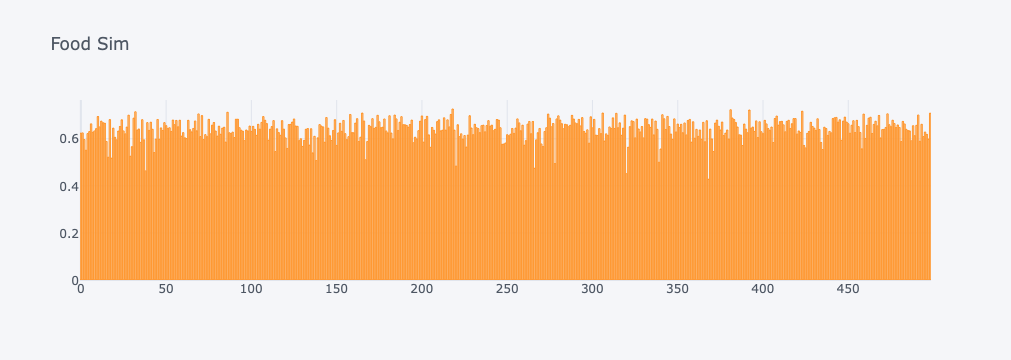

In [64]:
fourtopics_sim.query('search_term=="food"')[['spacy_sim_title_description_content']].iplot(kind='bar',title='Food Sim')

In [65]:
ST = list(fourtopics_sim.ST.unique())

In [ ]:
# compare = pd.DataFrame()
# for st in ST:
#     temp = fourtopics_sim.query('ST=="{st}"'.format(st=st))[['spacy_sim_title_description_content']].\
#                                     rename(columns={'spacy_sim_title_description_content':'{st}'.format(st=st)}).describe().T\
#                                     [['min','mean','75%','max']]
#     compare = pd.concat([compare,temp])
# sample = df_sample_sim[['spacy_sim_title_description_content']].rename(columns={'spacy_sim_title_description_content':'sample'}).describe().T[['min','mean','75%','max']]
# compare = pd.concat([sample,compare])

In [68]:
fourtopics_sim.columns

Index(['spacy_sim_title_description_content', 'title_description_content',
       'title_description', 'news_id', 'source_name', 'author', 'title',
       'content', 'description', 'publishedAt', 'search_term', 'url', 'ST'],
      dtype='object')

In [69]:
compare = pd.DataFrame()
for st in ST:
    temp = fourtopics_sim.query('ST=="{st}"'.format(st=st))[['spacy_sim_title_description_content']].\
                                    rename(columns={'spacy_sim_title_description_content':'{st}'.format(st=st)}).describe().T\
                                    [['min','mean','75%','max']]
    compare = pd.concat([compare,temp])
sample = df_sample_sim[['spacy_sim_Content']].rename(columns={'spacy_sim_Content':'sample'}).describe().T[['min','mean','75%','max']]
compare = pd.concat([sample,compare])

In [70]:
compare

,min,mean,75%,max
sample,0.596735,0.695445,0.712441,0.736417
food,0.428094,0.640083,0.670952,0.726349
sport,0.287714,0.609222,0.648216,0.716761
financial stability,0.197839,0.639209,0.669420,0.717186
foreign policy,0.419815,0.668915,0.692419,0.732032
armed conflict,0.465676,0.680270,0.696680,0.736726
terrorist,0.251394,0.664918,0.701131,0.739732
corruption,0.312829,0.661965,0.699137,0.732488


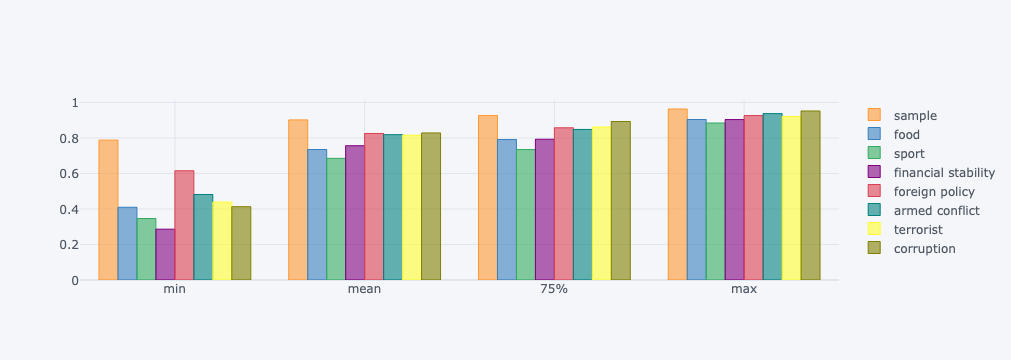

In [150]:
compare.T.iplot(kind='bar')

In [131]:
fourtopics_sim.query('ST=="corruption" and spacy_sim_title_description_content>0.9263').shape

(17, 13)

In [116]:
kw_cluster_str = ", ".join([i for i in kw_cluster.kw.to_list()])
kw_cluster_str

'tyrannical, authoritarian, dictatorial, kleptocratic, authoritarianism, oppressive, despotic, oligarchy, undemocratic, autocratic, allegations of corruption, cronyism, electoral fraud, systemic corruption, nepotism, chronic corruption, graft, fight corruption, corrupt officials, embezzlement, alleged corruption, corruption, inequality, corruption scandals, bribery, drug trafficking, highlevel corruption, endemic corruption, corrupt, maladministration, corrupted, injustice, entrenched corruption, corrupt and repressive, widespread corruption, corrupt practices, anti corruption, corrupt regime, fraud, rampant corruption, people, election, money laundering, president, central bank, government, military, morally bankrupt, accept bribe, protest, gender inequality, tax evasion, human right, rising crime, country, organized crime, rights abuses, abuse of power, prime minister, attorney general, venal, powerhungry'

In [119]:
nlp(kw_cluster_str).similarity(nlp(kw_cluster_str))

1.0

In [242]:
KEY_WORDS = list(set(kw_cluster.kw.to_list()))

In [243]:
KEY_WORDS

['highlevel corruption',
 'government',
 'kleptocratic',
 'despotic',
 'authoritarian',
 'undemocratic',
 'endemic corruption',
 'anti corruption',
 'central bank',
 'tyrannical',
 'bribery',
 'corrupt',
 'corrupt officials',
 'nepotism',
 'corrupt practices',
 'military',
 'organized crime',
 'maladministration',
 'corrupted',
 'fight corruption',
 'president',
 'human right',
 'authoritarianism',
 'fraud',
 'autocratic',
 'rising crime',
 'rampant corruption',
 'systemic corruption',
 'entrenched corruption',
 'alleged corruption',
 'corrupt and repressive',
 'rights abuses',
 'corruption scandals',
 'oligarchy',
 'widespread corruption',
 'cronyism',
 'people',
 'venal',
 'country',
 'money laundering',
 'protest',
 'dictatorial',
 'powerhungry',
 'injustice',
 'abuse of power',
 'prime minister',
 'chronic corruption',
 'electoral fraud',
 'inequality',
 'drug trafficking',
 'corrupt regime',
 'graft',
 'tax evasion',
 'allegations of corruption',
 'attorney general',
 'gender ineq

In [237]:
KEY_WORDS = ['"{i}"'.format(i=i)  if ' ' in i else i for i in kw_cluster.kw.to_list()]

In [238]:
KEY_WORDS

['tyrannical',
 'authoritarian',
 'dictatorial',
 'kleptocratic',
 'authoritarianism',
 'oppressive',
 'despotic',
 'oligarchy',
 'undemocratic',
 'autocratic',
 '"allegations of corruption"',
 'cronyism',
 '"electoral fraud"',
 '"systemic corruption"',
 'nepotism',
 '"chronic corruption"',
 'graft',
 '"fight corruption"',
 '"corrupt officials"',
 'embezzlement',
 '"alleged corruption"',
 'corruption',
 'inequality',
 '"corruption scandals"',
 'bribery',
 '"drug trafficking"',
 '"highlevel corruption"',
 '"endemic corruption"',
 'corrupt',
 'maladministration',
 'corrupted',
 'injustice',
 '"entrenched corruption"',
 '"corrupt and repressive"',
 '"widespread corruption"',
 '"corrupt practices"',
 '"anti corruption"',
 '"corrupt regime"',
 'fraud',
 '"rampant corruption"',
 'people',
 'election',
 '"money laundering"',
 'president',
 '"central bank"',
 'government',
 'military',
 '"morally bankrupt"',
 '"accept bribe"',
 'protest',
 '"gender inequality"',
 '"tax evasion"',
 '"human righ

In [25]:
from time import time
from newsapi import NewsApiClient
from IPython.display import clear_output
import pandas as pd
import string
import random
import uuid
from tqdm.notebook import trange, tqdm


newsparams = [KEY_WORDS,'2022-01-01','2022-06-25',60,'relevancy']

newsapi = NewsApiClient(api_key='60753360cc434982b3c88e81d8b07743')

def Extract_Google_News(topics, 
                        date_from:str, 
                        date_to:str, 
                        n_page:int, 
                        sort_by:str,**kwargs):
    
    # sort_by belongs to 'relevancy', 'popularity', 'publishedAt'
    
#     date_rng = pd.date_range(date_from, date_to,freq='1D')
#     date_list = date_rng.strftime("%Y-%m-%d").tolist()
    
    df_all_articles = pd.DataFrame()

    if n_page <=99:
        if type(KEY_WORDS)==list: 
            for j in tqdm(topics):           
                    for i in range(1,n_page+1,1):
                        articles_page = newsapi.get_everything(
                                                                q=j,
                                                                from_param= date_from,
                                                                to= date_to,
                                                                page_size = 100,
                                                                language='en',
                                                                sort_by= sort_by,
                                                                page=i)

                        #clear_output(wait=True)
                        print("Retrieved news topic '{topic}', page {page} ".format(topic=j,page=i))
                        df_articles_page = pd.DataFrame(articles_page['articles'])
                        df_articles_page['search_term'] = '{search_term}'.format(search_term = j) 

                        df_all_articles = df_all_articles.append(df_articles_page,ignore_index=True)

        elif type(KEY_WORDS)==str:

            for i in range(1,n_page+1,1):
                articles_page = newsapi.get_everything(q=KEY_WORDS,
                                                      from_param= date_from,
                                                      to= date_to,
                                                      page_size = 100,
                                                      language='en',
                                                      sort_by= sort_by,
                                                      page=i)

                print("Retrieved page {page}".format(page=i))

                df_articles_page = pd.DataFrame(articles_page['articles'])
                df_all_articles = df_all_articles.append(df_articles_page,ignore_index=True)

    else:
      print('ERROR: Max number of pages is 99.')
                
    return df_all_articles


def Transform_G_News(dataset):

    source_list = [list(eval(str(dataset.source[i])).values()) for i in range(len(dataset['source']))]

    source_df = pd.DataFrame(source_list,
                             columns=['source_id','source_name'],
                             index = dataset.index)

    dataset = pd.concat([source_df,dataset],axis=1)

    # drop duplicate title   
    n_duplicates = (len(dataset.title)-len(dataset.title.unique()))
    if n_duplicates > 0:        
        print('{n} duplicate news articles are dropped '.format(n=n_duplicates))
        print('-'*80)
    
    dataset = dataset.drop_duplicates(subset='title',keep='first')

    # drop empty news content
    # dataset = dataset.dropna(subset=['content'])
    dataset = dataset.query('content==content')

    news_id = []
    for i in range(len(dataset)):    
        digit = uuid.uuid4()    
        # n = (ran_gen(16, "AEIOSUMA23"))   
        news_id.append(digit)

    df_news_id = pd.DataFrame(news_id, index = dataset.index, columns = ['news_id'])
    dataset = pd.concat([df_news_id,dataset],axis=1)

    dataset.set_index('news_id',inplace=True)


    if type(KEY_WORDS)==list:

      col_order = ['source_name', 'author', 'title','content', 'description', 'publishedAt',\
                    'search_term','url' ]  # 'source','urlToImage','source_id'

    elif type(KEY_WORDS)==str:

      col_order = ['source_name', 'author', 'title','content', 'description', 'publishedAt','url']

    dataset = dataset[col_order]
    
    return dataset

def ETL():

    start = time()
    df_News = Extract_Google_News(*newsparams)
    print('-'*80)
    print(f'Extracting News finished with {time() - start:.2f} secs')  
    print('-'*80)
    df_News.to_csv('data/TT_Ori_2022_0101_0625.csv')
    
    start = time()
    df_News_transformed = Transform_G_News(dataset = df_News)
    df_News_transformed.to_csv('data/TT_trans_2022_0101_0625.csv')

    print('-'*80)
    return df_News_transformed

In [26]:
news = ETL()

  0%|          | 0/152 [00:00<?, ?it/s]

Retrieved news topic '"terrorist group"', page 1 
Retrieved news topic '"terrorist group"', page 2 
Retrieved news topic '"terrorist group"', page 3 
Retrieved news topic '"terrorist group"', page 4 
Retrieved news topic '"terrorist group"', page 5 
Retrieved news topic '"terrorist group"', page 6 
Retrieved news topic '"terrorist group"', page 7 
Retrieved news topic '"terrorist group"', page 8 
Retrieved news topic '"terrorist group"', page 9 
Retrieved news topic '"terrorist group"', page 10 
Retrieved news topic '"terrorist group"', page 11 
Retrieved news topic '"terrorist group"', page 12 
Retrieved news topic '"terrorist group"', page 13 
Retrieved news topic '"terrorist group"', page 14 
Retrieved news topic '"terrorist group"', page 15 
Retrieved news topic '"terrorist group"', page 16 
Retrieved news topic '"terrorist group"', page 17 
Retrieved news topic '"terrorist group"', page 18 
Retrieved news topic '"terrorist group"', page 19 
Retrieved news topic '"terrorist group"'

In [2]:
news = pd.read_csv('data/TT_trans_2022_0101_0625.csv')

In [12]:
news.shape

(142181, 9)

In [13]:
news.isnull().sum()

news_id            0
source_name        0
author         29333
title              0
content            0
description      463
publishedAt       10
search_term       10
url               10
dtype: int64

In [11]:
news = news.drop_duplicates(subset='title',keep='first')

In [14]:
news = news.query('search_term==search_term')

In [15]:
news.shape

(142171, 9)

In [31]:
len(list(news.search_term.unique()))

94

In [19]:
news = Combine_Col(news,'title','description')
news = Combine_Col(news,'title_description','content')

In [20]:
news.head(1)

,title_description_content,title_description,news_id,source_name,author,title,content,description,publishedAt,search_term,url
0,"ISIS Names a New Leader, but Says Little About...","ISIS Names a New Leader, but Says Little About...",425f5965-726a-48e1-acdc-42d5f4038547,New York Times,Ben Hubbard,"ISIS Names a New Leader, but Says Little About...","BEIRUT, Lebanon The Islamic State on Thursday ...",The terrorist group announced its new leader a...,2022-03-11T02:40:46Z,"""terrorist group""",https://www.nytimes.com/2022/03/10/world/middl...


In [18]:
import nltk
nltk.download('punkt')
# nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import string
import re
from nltk.corpus import stopwords
import pandas as pd
from tqdm import tqdm

def Pre_Processing(text):    
    
    tokens = word_tokenize(text)   
    # convert to lower case
    tokens = [w.lower() for w in tokens]    
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))   
    # remove punctuation from each word
    stripped = [re_punc.sub('', w) for w in tokens]   
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]   
    # filter out stop words
    stop_words = set(stopwords.words('english'))   
    words = [w for w in words if not w in stop_words]    
    return words


def Spacy_Similarity(dataset,col_name:str,target_text:str):
    
    sim = []
    # text_1 = " ".join(Pre_Processing(target_text))
    text_1 = target_text
    text_1 = nlp(text_1)
    for index, row in tqdm(dataset.iterrows()):
        text_2 = " ".join(Pre_Processing(row[col_name]))[:100000]
        text_2 = nlp(text_2)
        sim.append(text_1.similarity(text_2))
    
    df_sim = pd.DataFrame(sim,columns=['spacy_sim'+'_{col_name}'.format(col_name=col_name)],index=dataset.index)
        
    return pd.concat([df_sim,dataset],axis=1)

[nltk_data] Downloading package punkt to /home/jason/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [37]:
news.isnull().sum()

title_description_content        0
title_description                0
source_name                      0
author                       29232
title                            0
content                          0
description                    148
publishedAt                      0
search_term                      0
url                              0
dtype: int64

In [38]:
news = news.query('title_description_content ==title_description_content ')

In [24]:
top_50

'attack, terrorism, police, group, arrest, court, charge, government, terrorist, country, man, people, security, law, kill, threat, case, military, president, force, suspect, accord, operation, official, authority, member, public, leader, accuse, trial, region, work, add, agency, detain, political, know, family, lawyer, order, city, violence, international, investigation, carry, explosion, support, prosecutor, organisation, fighter'

In [23]:
%%time
df_sim = Spacy_Similarity(news,'title_description_content',top_50)

142171it [2:15:52, 17.44it/s]


CPU times: user 2h 15min 42s, sys: 23.6 s, total: 2h 16min 6s
Wall time: 2h 15min 52s


In [25]:
df_sim.rename(columns={'spacy_sim_title_description_content':'TDC_sim'},inplace=True)

In [26]:
df_sim.head(1)

,TDC_sim,title_description_content,title_description,news_id,source_name,author,title,content,description,publishedAt,search_term,url
0,0.695521,"ISIS Names a New Leader, but Says Little About...","ISIS Names a New Leader, but Says Little About...",425f5965-726a-48e1-acdc-42d5f4038547,New York Times,Ben Hubbard,"ISIS Names a New Leader, but Says Little About...","BEIRUT, Lebanon The Islamic State on Thursday ...",The terrorist group announced its new leader a...,2022-03-11T02:40:46Z,"""terrorist group""",https://www.nytimes.com/2022/03/10/world/middl...


In [72]:
df_sim.shape

(142171, 12)

In [75]:
df_sim.query('TDC_sim > 0.73').shape

(1064, 12)

In [93]:
TT_1064 = df_sim.query('TDC_sim > 0.73')

In [78]:
df_sim['ST'] = df_sim['search_term'].apply(lambda x: eval(x) if ' ' in x else x)

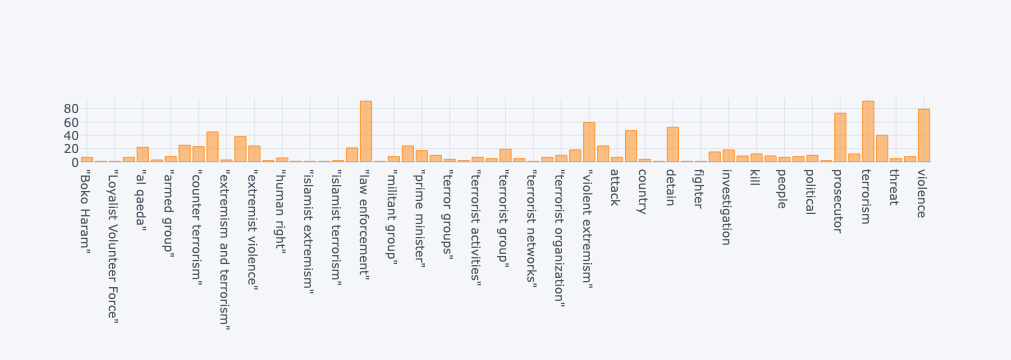

In [81]:
pd.DataFrame(TT_1064.reset_index().groupby(['search_term'])['news_id'].count()).iplot(kind='bar')

In [94]:
TT_1064.head(2)

,TDC_sim,title_description_content,title_description,news_id,source_name,author,title,content,description,publishedAt,search_term,url,ST
371,0.740340,"US woman charged with aiding IS, planning atta...","US woman charged with aiding IS, planning atta...",1511127e-8e89-4e14-b9f7-9fabd60b003a,The Punch,Agency Report,"US woman charged with aiding IS, planning attacks",An American woman who allegedly led an all-fem...,An American woman who allegedly led an all-fem...,2022-01-29T19:28:00Z,"""terrorist group""",https://punchng.com/us-woman-charged-with-aidi...,terrorist group
467,0.734194,AP calls for release of Ethiopian journalist i...,AP calls for release of Ethiopian journalist i...,521c727c-063f-4041-b043-08481ed3f947,Independent,Via AP news wire,AP calls for release of Ethiopian journalist i...,"Amir Aman Kiyaro, a freelance journalist accre...",The Associated Press and press freedom advocat...,2022-03-10T18:44:40Z,"""terrorist group""",https://www.independent.co.uk/news/new-york-ab...,terrorist group


In [95]:
order = ['Labeller','Primary Country','Primary Region','Primary City','Secondary Countries','Secondary Regions','Secondary Cities','Corruption','Internal Conflict','External Conflict','Terror Threat',\
'Financial Stability','Foreign Policy','Environment','Social','Governance','Comments']
for i in order:
    TT_1064[i] = ''

In [96]:
TT_1064.head(1)

,TDC_sim,title_description_content,title_description,news_id,source_name,author,title,content,description,publishedAt,...,Corruption,Internal Conflict,External Conflict,Terror Threat,Financial Stability,Foreign Policy,Environment,Social,Governance,Comments
371,0.74034,"US woman charged with aiding IS, planning atta...","US woman charged with aiding IS, planning atta...",1511127e-8e89-4e14-b9f7-9fabd60b003a,The Punch,Agency Report,"US woman charged with aiding IS, planning attacks",An American woman who allegedly led an all-fem...,An American woman who allegedly led an all-fem...,2022-01-29T19:28:00Z,...,,,,,,,,,,


In [97]:
TT_1064 = Check_KW_ST_in_TDC(df=TT_1064,kw='terrorist')

In [98]:
TT_1064.head(1)

,TDC_sim,title_description_content,title_description,news_id,source_name,author,title,content,description,publishedAt,...,Environment,Social,Governance,Comments,is_terrorist_in_content,is_terrorist_in_title,is_terrorist_in_desc,is_st_in_content,is_st_in_title,is_st_in_desc
371,0.74034,"US woman charged with aiding IS, planning atta...","US woman charged with aiding IS, planning atta...",1511127e-8e89-4e14-b9f7-9fabd60b003a,The Punch,Agency Report,"US woman charged with aiding IS, planning attacks",An American woman who allegedly led an all-fem...,An American woman who allegedly led an all-fem...,2022-01-29T19:28:00Z,...,,,,,yes,no,yes,yes,no,yes


In [99]:
TT_1064.to_excel('data/TT_1064.xlsx')

In [92]:
# df_sim['ST'] = df_sim['search_term'].apply(lambda x: eval(x))

In [100]:
df_sim.head(1)

,TDC_sim,title_description_content,title_description,news_id,source_name,author,title,content,description,publishedAt,search_term,url,ST
0,0.695521,"ISIS Names a New Leader, but Says Little About...","ISIS Names a New Leader, but Says Little About...",425f5965-726a-48e1-acdc-42d5f4038547,New York Times,Ben Hubbard,"ISIS Names a New Leader, but Says Little About...","BEIRUT, Lebanon The Islamic State on Thursday ...",The terrorist group announced its new leader a...,2022-03-11T02:40:46Z,"""terrorist group""",https://www.nytimes.com/2022/03/10/world/middl...,terrorist group


In [101]:
df_sim_check = Check_KW_ST_in_TDC(df=df_sim,kw='terrorist')

In [102]:
df_sim_check.head(1)

,TDC_sim,title_description_content,title_description,news_id,source_name,author,title,content,description,publishedAt,search_term,url,ST,is_terrorist_in_content,is_terrorist_in_title,is_terrorist_in_desc,is_st_in_content,is_st_in_title,is_st_in_desc
0,0.695521,"ISIS Names a New Leader, but Says Little About...","ISIS Names a New Leader, but Says Little About...",425f5965-726a-48e1-acdc-42d5f4038547,New York Times,Ben Hubbard,"ISIS Names a New Leader, but Says Little About...","BEIRUT, Lebanon The Islamic State on Thursday ...",The terrorist group announced its new leader a...,2022-03-11T02:40:46Z,"""terrorist group""",https://www.nytimes.com/2022/03/10/world/middl...,terrorist group,yes,no,yes,yes,no,yes


In [103]:
df_sim_check.to_csv('data/TT_sim_2022_0101_0625.csv')